In this notebook we will intersect the lysine modification positions from 'Lysine_modification_table_parsing' with the IDR positions from 'get_IDRs_Positions' (NML notebooks)

In [1]:
import pandas as pd
import os
import collections
import numpy as np
import urllib3
import json
import re
import CGAT.IOTools as IOTools
import time
import requests
from time import gmtime, strftime

from scipy.stats import binom_test
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
                         
import proteomics.d2p2 as d2p2
import proteomics.sequence as sequence

from bioservices import UniProt

%load_ext rpy2.ipython


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import importlib
importlib.reload(d2p2)
importlib.reload(sequence)

<module 'proteomics.sequence' from '/home/FILESERVER5/proteomics/tss38/git_repos/CamProt/camprot/proteomics/sequence.py'>

In [3]:
raw_base = '../raw/'
results = './results'
#  awk 'NR>1' results/lysine_modification.tsv | sort -k3 -k1 > results/lysine_modification_sorted.tsv
lysine_mod = os.path.join(results, 'lysine_modification_sorted.tsv')
idr_inf = "../../NML/hyperLOPIT-enrichment/notebooks/results/D2P2.tsv"
elm_inf = "../raw/elm.tsv.csv"
outfile = os.path.join(results, 'lysine_modifications_idr.tsv')
#idr_inf = "../../NML/hyperLOPIT-enrichment/notebooks/results/D2P2.bed"

In [4]:
idr_df = pd.read_table(idr_inf, sep="\t", index_col=0)
print(idr_df.head())

            start  end         Ensemble_ID             region_ID
Uniprot_ID                                                      
Q9DC51          1   34  ENSMUSP00000000001  ENSMUSP00000000001-0
P20615         17  193  ENSMUSP00000000010  ENSMUSP00000000010-0
P20615        229  250  ENSMUSP00000000010  ENSMUSP00000000010-1
Q9Z1X9        127  183  ENSMUSP00000000028  ENSMUSP00000000028-0
P09535        134  180  ENSMUSP00000000033  ENSMUSP00000000033-0


In [5]:
url = 'http://www.ebi.ac.uk/proteins/api/features?offset=0&accession='

http = urllib3.PoolManager()

response = http.request('GET', url + 'D3YU75')
text = json.loads(response.data.decode('utf8'))
print(text)
print(text[0]['sequence'])

[{'accession': 'D3YU75', 'sequenceChecksum': '306325968CB529CA', 'entryName': 'D3YU75_MOUSE', 'features': [{'category': 'DOMAINS_AND_SITES', 'end': '138', 'begin': '1', 'evidences': [{'source': {'name': 'PROSITE', 'id': 'PS51797', 'url': 'http://prosite.expasy.org/cgi-bin/prosite/get-prosite-raw.pl?PS51797'}, 'code': 'ECO:0000259'}], 'description': 'TCTP', 'type': 'DOMAIN'}], 'sequence': 'MVSRTEGAIDDSLIGGNASAEGPEGEGTESTVVTGVDIVMNHHLQETSFTKEAYKKYIKDYMKSLKGKLEEQKPERVKPFMTGAAEQIKHILANFNNYQFFIGENMNPDGMVALLDYREDGVTPFMIFFKDGLEMEKC', 'taxid': 10090}]
MVSRTEGAIDDSLIGGNASAEGPEGEGTESTVVTGVDIVMNHHLQETSFTKEAYKKYIKDYMKSLKGKLEEQKPERVKPFMTGAAEQIKHILANFNNYQFFIGENMNPDGMVALLDYREDGVTPFMIFFKDGLEMEKC


In [6]:
uniprot_ids = set()

with IOTools.openFile(lysine_mod, "r") as inf:
    header = next(inf)
    
    for line in inf:
        uniprot_id, position, modification, reference, ratio, p = line.strip().split("\t")
        uniprot_ids.add(uniprot_id)
print(len(uniprot_ids))

4368


In [7]:
u = UniProt()

u_results = u.search("organism:10090+and+reviewed:yes", columns="id,entry name", limit=-1)
uniprot_ids_df = pd.DataFrame.from_records(
        [x.split() for x in u_results.strip().split("\n")[1:]],
        columns=["uniprot_id", "name"])

print(len(uniprot_ids))
uniprot_ids = uniprot_ids.intersection(set(uniprot_ids_df['uniprot_id']))
print(len(uniprot_ids_df['uniprot_id']))
print(len(uniprot_ids))

4368
16858
2185


In [8]:
idr_data_available = set()
idr_data_unavailable = set()
sequence_length_idr = {}

blocks = collections.defaultdict(list)

n = 0

tools_whitelist = None
tools_blacklist = None
consensus_req = 4
min_block_size = 20


for d2p2_entry in d2p2.iterator(uniprot_ids):
    
    d2p2_entry.rebuildConsensus(
        tools_whitelist=tools_whitelist, tools_blacklist=tools_blacklist)
    
    d2p2_entry.setIDRs(consensus_req, min_block_size)
    
    blocks[d2p2_entry.name] = d2p2_entry.idrs

    idr_data_available.add(d2p2_entry.name)
    sequence_length_idr[d2p2_entry.name] = d2p2_entry.length
    
    n += 1
    if n%250 == 0:
        print('proteins done: %i %s' % (
                n, strftime("%Y-%m-%d %H:%M:%S", gmtime())))
    
idr_data_unavailable = uniprot_ids.difference(idr_data_available)

print(list(idr_data_available)[0])
print(blocks[list(idr_data_available)[0]])
print(len(idr_data_available))
print(len(idr_data_unavailable))


proteins done: 250 2017-05-03 07:39:51
proteins done: 500 2017-05-03 07:40:13
proteins done: 750 2017-05-03 07:40:35
proteins done: 1000 2017-05-03 07:40:54
proteins done: 1250 2017-05-03 07:41:13
proteins done: 1500 2017-05-03 07:41:29
proteins done: 1750 2017-05-03 07:41:44
proteins done: 2000 2017-05-03 07:41:58
Q61586
[(411, 459), (678, 702)]
2048
137


In [9]:
bases_in_motifs = collections.Counter()
elm_blocks = collections.defaultdict(set)
elm_data_available = set()
with IOTools.openFile(elm_inf, "r") as inf:
    header = next(inf)
    for line in inf:
        line = line.strip().split("\t")
        uniprot_id = line[4]
        start = int(line[6])
        end = int(line[7])
        elm_blocks[uniprot_id].add((start-1, end+1))
        elm_data_available.add(uniprot_id)
        
for accession, tax_id, seq, method in sequence.getSequences(elm_blocks.keys()):
    if seq is not None:
        for block in elm_blocks[accession]:
            motif = seq[block[0]: block[1]]
            #print(motif)
            for base in motif:
                bases_in_motifs[base] += 1
            #break

for base in bases_in_motifs.most_common():
    print(base)

('P', 280)
('S', 207)
('L', 198)
('R', 188)
('E', 154)
('G', 122)
('T', 120)
('Q', 119)
('K', 112)
('A', 111)
('V', 108)
('D', 104)
('I', 88)
('F', 83)
('Y', 72)
('N', 62)
('W', 39)
('H', 36)
('M', 35)
('C', 25)


Ok, so we have 112 Ks in total. Not all these will be covered in the lysine modification peptides so we probably wont have enough covered Ks to perform the SIRT5 comparison

In [10]:
descriptions = collections.Counter()
nes_url = ('https://www.ebi.ac.uk/proteins/api/features?size=10000'
           '&taxid=10090&categories=DOMAINS_AND_SITES&types=TRANSIT&reviewed=true')
print(nes_url)
r = requests.get(nes_url, headers={ "Accept" : "application/json"})
text = json.loads(r.text)
for p_ix in text:
    for motif in p_ix['features']:
        if 'description' in motif:
            descriptions[motif['description']]+= 1

for x in descriptions.most_common():
    if x[1]>10:
        print(x)

https://www.ebi.ac.uk/proteins/api/features?size=10000&taxid=10090&categories=DOMAINS_AND_SITES&types=TRANSIT&reviewed=true


In [11]:
nes_data_available = set(uniprot_ids_df['uniprot_id'])
nes_blocks = collections.defaultdict(list)
nes_url = ('https://www.ebi.ac.uk/proteins/api/features?size=10000'
           '&taxid=10090&categories=DOMAINS_AND_SITES&types=TRANSIT&reviewed=true')
print(nes_url)
r = requests.get(nes_url, headers={ "Accept" : "application/json"})
text = json.loads(r.text)
for p_ix in text:
    for motif in p_ix['features']:
        if 'Mitochondrion' in motif['description']:
            try:
                nes_blocks[p_ix['accession']].append((int(motif['begin']), int(motif['end'])))
            except:
                pass #print(motif, p_ix['accession'])


https://www.ebi.ac.uk/proteins/api/features?size=10000&taxid=10090&categories=DOMAINS_AND_SITES&types=TRANSIT&reviewed=true


In [12]:
ks_in_nes = 0
nes_proteins = 0
for protein in nes_blocks:
    if len(nes_blocks[protein]) > 0:
        nes_proteins += 1
        seq, method = sequence.getSequence(protein)
        for block in nes_blocks[protein]:
            ks_in_nes += seq[block[0] - 1: block[1]].count("K")
            #print(protein, nes_blocks[protein], seq[block[0] - 1: block[1]], len(seq), seq[-4:])
        #if ks_in_nes > 0:
            #print(protein, nes_blocks[protein], seq[block[0] - 1: block[1]])
            #break

print(ks_in_nes)
print(nes_proteins)

0
0


In [13]:
nls_data_available = set(uniprot_ids_df['uniprot_id'])
nls_blocks = collections.defaultdict(list)
nls_url = ('https://www.ebi.ac.uk/proteins/api/features?size=10000'
           '&taxid=10090&categories=DOMAINS_AND_SITES&types=MOTIF&reviewed=true')
print(nls_url)
r = requests.get(nls_url, headers={ "Accept" : "application/json"})
text = json.loads(r.text)
for p_ix in text:
    for motif in p_ix['features']:
        if 'Nuclear localization signal' in motif['description']:
            nls_blocks[p_ix['accession']].append((int(motif['begin']), int(motif['end'])))



https://www.ebi.ac.uk/proteins/api/features?size=10000&taxid=10090&categories=DOMAINS_AND_SITES&types=MOTIF&reviewed=true


In [14]:
ks_in_nls = 0
nls_proteins = 0
for protein in nls_blocks:
    if len(nls_blocks[protein]) > 0:
        nls_proteins += 1
        seq, method = sequence.getSequence(protein)

        for block in nls_blocks[protein]:
            ks_in_nls += seq[block[0] - 1: block[1]].count("K")
        #if ks_in_nes > 0:
            #print(protein, nes_blocks[protein], seq[block[0] - 1: block[1]])
            #break
print(ks_in_nls)
print(nls_proteins)

1373
383


In [15]:
references = collections.Counter()
with IOTools.openFile(lysine_mod, "r") as inf:
    header = next(inf)
    for line in inf:
        reference = line.split("\t")[3]
        references[reference] += 1
print(references)

Counter({'Weinert_et_al_2013': 6221, 'Sol_et_al_2012': 4847, 'Colaka_et_al_2015': 4209, 'Park_et_al_2013': 1085, 'Nishida_et_al_2015': 1043, 'Rardin_et_al_2013': 996, 'Tan_et_al_2014': 825, 'Sadhukhan_et_al_2016': 119, 'Reference': 1})


In [16]:

url='http://www.ebi.ac.uk/proteins/api/features?offset=0&accession=Q99J08,Q3U8R2,Q9CQE1,Q8K2C9,Q7TSZ3,Q8C3Y4,O09173,Q61264,Q9JI39,Q9CR86,Q9CPR4,B0LAA9,Q5SW88,A2A8U2,P68181,Q5DTL1,Q3TCR7,Q8C243,Q9Z2Q5,Q6NZB5,Q810V2,O08582,Q9CX98,Q6S388,Q3UGP8,B2RSN1,A2AMV7,P61458,P28665,O55137,Q60598,Q7TMW1,Q7TMY8,Q8BGY2,Q61576,Q3UA25,Q8C5W0,Q1A602,P63323,Q64458,Q3UJV2,Q8VC94,B1AUX2,P10649,P17563,Q3UD94,Q9D1A2,Q9D809,Q545G0,A2AVJ7,G3X9Y6,P86048,D3Z5I1,Q4KML7,Q8BHG2-3,Q9CRH1,Q3TL79,Q9DC51,P84099,Q14BR4,P80317,Q8K1M6-2,Q921B8,P97868,Q80X90,Q9JMD0,A2A6A2,B7ZCF1,B7ZNQ1,Q6P3D0,Q8CCM0,Q8BYJ6,Q99PP7,Q3U561,Q64356,Q3UNW7,O08915,Q8JZV7,Q6P5E5,Q9D0K2,Q99KG1,Q9Z2L5,Q3TKA2,D3YZ29,Q3UMA3,Q64471,Q7TMI0,Q3U5V3,B0R1E3,Q61335,Q8CG72,Q9CQZ6,Q9DCP2,Q3ULU4,P62830,Q6PB36,Protein,Q61211-2,P61924,Q9CVB6'
http = urllib3.PoolManager()
response = http.request('GET', url)
text = json.loads(response.data.decode('utf8'))
if text['errorMessage']:
    print(text)


{'errorMessage': ["The accession parameter 'Protein' has invalid format. It should be a valid UniProtKB accession."], 'requestedURL': 'http://www.ebi.ac.uk/proteins/api/features?offset=0&accession=Q99J08,Q3U8R2,Q9CQE1,Q8K2C9,Q7TSZ3,Q8C3Y4,O09173,Q61264,Q9JI39,Q9CR86,Q9CPR4,B0LAA9,Q5SW88,A2A8U2,P68181,Q5DTL1,Q3TCR7,Q8C243,Q9Z2Q5,Q6NZB5,Q810V2,O08582,Q9CX98,Q6S388,Q3UGP8,B2RSN1,A2AMV7,P61458,P28665,O55137,Q60598,Q7TMW1,Q7TMY8,Q8BGY2,Q61576,Q3UA25,Q8C5W0,Q1A602,P63323,Q64458,Q3UJV2,Q8VC94,B1AUX2,P10649,P17563,Q3UD94,Q9D1A2,Q9D809,Q545G0,A2AVJ7,G3X9Y6,P86048,D3Z5I1,Q4KML7,Q8BHG2-3,Q9CRH1,Q3TL79,Q9DC51,P84099,Q14BR4,P80317,Q8K1M6-2,Q921B8,P97868,Q80X90,Q9JMD0,A2A6A2,B7ZCF1,B7ZNQ1,Q6P3D0,Q8CCM0,Q8BYJ6,Q99PP7,Q3U561,Q64356,Q3UNW7,O08915,Q8JZV7,Q6P5E5,Q9D0K2,Q99KG1,Q9Z2L5,Q3TKA2,D3YZ29,Q3UMA3,Q64471,Q7TMI0,Q3U5V3,B0R1E3,Q61335,Q8CG72,Q9CQZ6,Q9DCP2,Q3ULU4,P62830,Q6PB36,Protein,Q61211-2,P61924,Q9CVB6'}


In [17]:
lysine_uniprot_ids = set()

with IOTools.openFile(lysine_mod, "r") as inf:
    header = next(inf)
    
    for line in inf:
        uniprot_id, position, modification, reference, ratio, p = line.strip().split("\t")
        lysine_uniprot_ids.add(uniprot_id)
  

In [18]:
seq1 = "AAASKALASALKSAARKARA"
seq2 = "AAASKALASALKSAARAARA"

if re.search("[KR]{2}", seq1):
    print("yes")
print(re.search("[KR][KR]", seq2))

yes
None


In [19]:
krepeats_data_available = set()
krepeats_blocks = collections.defaultdict(list)

ks_in_krepeats = 0
krepeats_proteins = 0

for accession, tax_id, seq, method in sequence.getSequences(list(
        lysine_uniprot_ids.intersection(set(uniprot_ids_df['uniprot_id'])))):
    if seq is not None:
        krepeats_data_available.add(accession)
        if re.search("[KR]{2}", seq):
            krepeats_proteins += 1

            for m in re.finditer("[KR]{2,100}", seq):
                krepeats_blocks[accession].append((m.start(), m.end()))            
                ks_in_krepeats += m.end() - m.start()

print(len(krepeats_data_available))
print(len(krepeats_blocks))
print(krepeats_proteins)
print(ks_in_krepeats)


2185
2134
2134
37284


In [20]:
print(len(idr_data_available))
print(len(nls_data_available))
print(len(krepeats_data_available))
print(len(elm_data_available))


2048
16858
2185
208


In [21]:
n = 0
current_protein = None
modifications = collections.defaultdict(set)
protein_lines = []

tmp_idr_df = None
skip = True
outf = IOTools.openFile(outfile, "w")

proteins_done = 0

total_trial_idr = collections.Counter()
total_lysines_idr = collections.Counter()
total_in_idr = collections.Counter()
total_lysines_in_idr = collections.Counter()

total_trial_nls = collections.Counter()
total_lysines_nls = collections.Counter()
total_in_nls = collections.Counter()
total_lysines_in_nls = collections.Counter()

total_trial_krepeats = collections.Counter()
total_lysines_krepeats = collections.Counter()
total_in_krepeats = collections.Counter()
total_lysines_in_krepeats = collections.Counter()

total_trial_elm = collections.Counter()
total_lysines_elm = collections.Counter()
total_in_elm = collections.Counter()
total_lysines_in_elm = collections.Counter()

lines = 0 
different_lengths = 0
remove_modifications_not_overlapping_lysine = 0
total_remove_modifications_not_overlapping_lysine = 0

ratio_idr = []

modifications_counter = collections.Counter()
modifications_counter_skipped = collections.Counter()
modifications_counter_not_skipped = collections.Counter()

with IOTools.openFile(lysine_mod, "r") as inf:
    header = next(inf)
    
    for line in inf:
        lines += 1
        uniprot_id, position, modification, reference, ratio, p = line.strip().split("\t")

            
        modifications_counter[modification] += 1
        if len(position)==0:
            continue

        if uniprot_id != current_protein:
            
            if not skip:
                proteins_done += 1


                if proteins_done % 100 == 0:
                    print('proteins done: %i %s' % (
                            proteins_done, strftime("%Y-%m-%d %H:%M:%S", gmtime())))

                for p_line in protein_lines:

                    if current_protein in idr_data_available:
                        in_idr = False
                        for block in blocks[current_protein]:
                            start, end = block
                            tmp_position = int(p_line[1])
                            if tmp_position >= start and tmp_position <= end:
                                in_idr = True
                                break
                    else:
                        in_idr = np.nan


                    if current_protein in nls_data_available:
                        in_nls = False
                        for block in nls_blocks[current_protein]:
                            start, end = block
                            tmp_position = int(p_line[1])
                            if tmp_position >= start and tmp_position <= end:
                                in_nls = True
                                break
                    else:
                        in_nls = np.nan
                            
                            
                    if current_protein in krepeats_data_available:
                        in_krepeats = False
                        len_krepeats = 1
                        for block in krepeats_blocks[current_protein]:
                            start, end = block
                            tmp_position = int(p_line[1])
                            if tmp_position >= start and tmp_position <= end:
                                in_krepeats = True
                                len_krepeats = end - start
                                break
                    else:
                        in_krepeats = np.nan
                        len_krepeats = np.nan


                    if current_protein in elm_data_available:
                        in_elm = False
                        for block in elm_blocks[current_protein]:
                            start, end = block
                            tmp_position = int(p_line[1])
                            if tmp_position >= start and tmp_position <= end:
                                in_elm = True
                                break
                    else:
                        in_elm = np.nan

                            
                    p_line.extend((in_idr, in_nls, in_krepeats, len_krepeats, in_elm))
                    ratio_idr.append(p_line)
                                    
                if len(modifications) > 0:

                    modifications['acyl_competitive'] = modifications['succinylation'].intersection(
                        modifications['malonylation'])

                    modifications['all_competitive'] = modifications['acyl_competitive'].intersection(
                        modifications['acetylation'])

                    seq, method = sequence.getSequence(current_protein)
                    if seq is None:
                        skip = True
                        print("sequence not available: %s" % current_protein)

                    else:
                        #if len(seq) == sequence_length_idr[current_protein]:

                        # determine the positions of lysines which could be observed
                        # note this ignores 'flyability' entirely!
                        # allows for two missed cleavages

                        lysine_positions = set()

                        for peptide in sequence.iteratePeptides(seq, 'trypsin', 2, 4, 40):
                            pep_seq, start, end, missed = peptide
                            lysine_positions.update(
                                [m.start() + start + 1 for m in re.finditer("K", pep_seq)])

                        if not set(modifications[modification]).issubset(lysine_positions):

                            remove_modifications_not_overlapping_lysine += 1                                

                            total_remove_modifications_not_overlapping_lysine += len(
                                modifications[modification].difference(lysine_positions))
                            modifications[modification] = list(
                                modifications[modification].intersection(lysine_positions))

                        lysine_in_idr = 0
                        lysine_in_nls = 0
                        lysine_in_krepeats = 0
                        lysine_in_elm = 0
                        
                        for l_position in lysine_positions:

                            for block in blocks[current_protein]:
                                start, end = block
                                if l_position >= start and l_position <= end:
                                    lysine_in_idr += 1
                                    break

                            for block in nls_blocks[current_protein]:
                                start, end = block
                                if l_position >= start and l_position <= end:
                                    lysine_in_nls += 1
                                    break

                            for block in krepeats_blocks[current_protein]:
                                start, end = block
                                if l_position >= start and l_position <= end:
                                    lysine_in_krepeats += 1
                                    break

                            for block in elm_blocks[current_protein]:
                                start, end = block
                                if l_position >= start and l_position <= end:
                                    lysine_in_elm += 1
                                    break
                                    
                        for modification in modifications:
                            mod_in_idr = 0
                            mod_in_nls = 0
                            mod_in_krepeats = 0
                            mod_in_elm = 0

                            for m_position in modifications[modification]:

                                for block in blocks[current_protein]:
                                    start, end = block
                                    if m_position >= start and m_position <= end:
                                        mod_in_idr += 1
                                        break

                                for block in nls_blocks[current_protein]:
                                    start, end = block
                                    if m_position >= start and m_position <= end:
                                        mod_in_nls += 1
                                        break

                                for block in krepeats_blocks[current_protein]:
                                    start, end = block
                                    if m_position >= start and m_position <= end:
                                        mod_in_krepeats += 1
                                        break
                                        
                                for block in elm_blocks[current_protein]:
                                    start, end = block
                                    if m_position >= start and m_position <= end:
                                        mod_in_elm += 1
                                        break

                            trials = len(modifications[modification])
                            null_trials = len(lysine_positions)

                            if trials > 0:

                                if current_protein in idr_data_available:
                                    total_trial_idr[modification] += trials
                                    total_lysines_idr[modification] += null_trials

                                    total_in_idr[modification] += mod_in_idr
                                    total_lysines_in_idr[modification] += lysine_in_idr

                                if current_protein in nls_data_available:
                                    total_in_nls[modification] += mod_in_nls
                                    total_lysines_in_nls[modification] += lysine_in_nls

                                    total_trial_nls[modification] += trials
                                    total_lysines_nls[modification] += null_trials

                                if current_protein in krepeats_data_available:
                                    total_in_krepeats[modification] += mod_in_krepeats
                                    total_lysines_in_krepeats[modification] += lysine_in_krepeats

                                    total_trial_krepeats[modification] += trials
                                    total_lysines_krepeats[modification] += null_trials

                                if current_protein in elm_data_available:
                                    total_in_elm[modification] += mod_in_elm
                                    total_lysines_in_elm[modification] += lysine_in_elm

                                    total_trial_elm[modification] += trials
                                    total_lysines_elm[modification] += null_trials


            
            current_protein = uniprot_id
            if (uniprot_id in idr_data_available):

                skip = False
                modifications = collections.defaultdict(set)
                modifications[modification].add(int(position))
                protein_lines=[line.strip().split("\t")]
            else:
                skip = True
            
        else:
            if not skip:
                modifications_counter_not_skipped[modification] +=1
                modifications[modification].add(int(position))
                protein_lines.append(line.strip().split("\t"))
            else:
                modifications_counter_skipped[modification] +=1
                

print('done')
print("different lengths: ", different_lengths)
print("Proteins where at least some of the apparently modified sites "
      "are not in lysines which should be accessible! :\n",
      remove_modifications_not_overlapping_lysine,
      total_remove_modifications_not_overlapping_lysine)
print(modifications_counter)
print(modifications_counter_skipped)
print(modifications_counter_not_skipped)


proteins done: 100 2017-05-03 07:43:02
proteins done: 200 2017-05-03 07:43:07
proteins done: 300 2017-05-03 07:43:11
proteins done: 400 2017-05-03 07:43:14
proteins done: 500 2017-05-03 07:43:18
proteins done: 600 2017-05-03 07:43:22
proteins done: 700 2017-05-03 07:43:26
proteins done: 800 2017-05-03 07:43:30
proteins done: 900 2017-05-03 07:43:34
proteins done: 1000 2017-05-03 07:43:38
proteins done: 1100 2017-05-03 07:43:42
proteins done: 1200 2017-05-03 07:43:46
proteins done: 1300 2017-05-03 07:43:50
proteins done: 1400 2017-05-03 07:43:53
proteins done: 1500 2017-05-03 07:43:57
proteins done: 1600 2017-05-03 07:44:00
proteins done: 1700 2017-05-03 07:44:04
proteins done: 1800 2017-05-03 07:44:08
proteins done: 1900 2017-05-03 07:44:12
proteins done: 2000 2017-05-03 07:44:15
done
different lengths:  0
Proteins where at least some of the apparently modified sites are not in lysines which should be accessible! :
 1 1
Counter({'acetylation': 8928, 'malonylation': 5252, 'succinylation

In [22]:
ratio_df = pd.DataFrame.from_records(
    ratio_idr, columns=["uniprot_id", "position", "modification", "reference",
                        "ratio", "p_value", "in_idr", "in_nls", "in_krepeats", "len_repeats", "in_elm"])

print(ratio_df[ratio_df['uniprot_id']=="Q9JLT4"])

      uniprot_id position   modification             reference ratio p_value  \
12154     Q9JLT4      215    acetylation    Weinert_et_al_2013    -1      -1   
12155     Q9JLT4      215  succinylation    Weinert_et_al_2013    -1      -1   
12156     Q9JLT4      329    acetylation    Weinert_et_al_2013    -1      -1   
12157     Q9JLT4      329  succinylation       Park_et_al_2013    -1      -1   
12158     Q9JLT4      329  succinylation    Weinert_et_al_2013    -1      -1   
12159     Q9JLT4      337  succinylation       Park_et_al_2013    -1      -1   
12160     Q9JLT4      337  succinylation  Sadhukhan_et_al_2016  1.47      -1   
12161     Q9JLT4      337  succinylation    Weinert_et_al_2013    -1      -1   

      in_idr in_nls in_krepeats  len_repeats in_elm  
12154  False  False       False            1    NaN  
12155  False  False       False            1    NaN  
12156  False  False       False            1    NaN  
12157  False  False       False            1    NaN  
12158  Fa

In [23]:
ratio_df.to_csv("./results/ratio_df.tsv", sep="\t", index=False)

In [24]:
print(modifications_counter)
print(modifications_counter_skipped)
print(modifications_counter_not_skipped)

Counter({'acetylation': 8928, 'malonylation': 5252, 'succinylation': 4232, 'glutarylation': 825, 'succinylation_SIRT5_KO': 108, 'Modification': 1})
Counter({'acetylation': 2220, 'malonylation': 636, 'succinylation': 480, 'succinylation_SIRT5_KO': 9})
Counter({'malonylation': 3691, 'acetylation': 3664, 'succinylation': 3403, 'succinylation_SIRT5_KO': 72})


In [25]:
print("\n--- IDR ---\n")
print(total_trial_idr)
print(total_lysines_idr)
print(total_in_idr)
print(total_lysines_in_idr)

print("\n--- NLS ---\n")
print(total_trial_nls)
print(total_lysines_nls)
print(total_in_nls)
print(total_lysines_in_nls)

print("\n--- K-repeats ---\n")
print(total_trial_krepeats)
print(total_lysines_krepeats)
print(total_in_krepeats)
print(total_lysines_in_krepeats)


print("\n--- ELM ---\n")
print(total_trial_elm)
print(total_lysines_elm)
print(total_in_elm)
print(total_lysines_in_elm)


for modification in modifications:
    print("\n--- Modification: ---\n")
    print(modification)
    
    print(total_trial_idr[modification])
    print(total_lysines_idr[modification])
    print(total_in_idr[modification])
    print(total_lysines_in_idr[modification])
    
    print(total_trial_nls[modification])
    print(total_lysines_nls[modification])
    print(total_in_nls[modification])
    print(total_lysines_in_nls[modification])
    
    print(total_trial_krepeats[modification])
    print(total_lysines_krepeats[modification])
    print(total_in_krepeats[modification])
    print(total_lysines_in_krepeats[modification])

    print("\n--- IDR ---\n")
    chi2, p, fod, exp = chi2_contingency(
        [[total_in_idr[modification], total_trial_idr[modification]],
         [total_lysines_in_idr[modification], total_lysines_idr[modification]]],
        lambda_="log-likelihood")
    print(chi2, p, fod, exp)
    print(binom_test(total_in_idr[modification], total_trial_idr[modification],
                     total_lysines_in_idr[modification] / total_lysines_idr[modification]))
    

    print("\n--- NLS ---\n")
    chi2, p, fod, exp = chi2_contingency(
        [[total_in_nls[modification], total_trial_nls[modification]],
         [total_lysines_in_nls[modification], total_lysines_nls[modification]]],
        lambda_="log-likelihood")
    print(chi2, p, fod, exp)
    print(binom_test(total_in_nls[modification], total_trial_nls[modification],
                     total_lysines_in_nls[modification] / total_lysines_nls[modification]))
    
    print("\n--- K-repeats ---\n")
    if total_lysines_in_krepeats[modification]>0:
        chi2, p, fod, exp = chi2_contingency(
        [[total_in_krepeats[modification], total_trial_krepeats[modification]],
         [total_lysines_in_krepeats[modification], total_lysines_krepeats[modification]]],
        lambda_="log-likelihood")
        print(chi2, p, fod, exp)
        print(binom_test(total_in_krepeats[modification], total_trial_krepeats[modification],
                         total_lysines_in_krepeats[modification] / total_lysines_krepeats[modification]))
    
    print("\n--- ELM ---\n")
    if total_lysines_in_elm[modification]>0:
        chi2, p, fod, exp = chi2_contingency(
        [[total_in_elm[modification], total_trial_elm[modification]],
         [total_lysines_in_elm[modification], total_lysines_elm[modification]]],
        lambda_="log-likelihood")
        print(chi2, p, fod, exp)
        print(binom_test(total_in_elm[modification], total_trial_elm[modification],
                         total_lysines_in_elm[modification] / total_lysines_elm[modification]))

print(len(idr_data_available))
print(len(idr_data_unavailable))


outf.close()
print(lines)


--- IDR ---

Counter({'malonylation': 3824, 'acetylation': 3696, 'succinylation': 2621, 'acyl_competitive': 989, 'all_competitive': 519, 'succinylation_SIRT5_KO': 78})
Counter({'malonylation': 45809, 'acetylation': 43744, 'succinylation': 21228, 'acyl_competitive': 11671, 'all_competitive': 7182, 'succinylation_SIRT5_KO': 3068})
Counter({'malonylation': 547, 'acetylation': 425, 'succinylation': 170, 'acyl_competitive': 72, 'all_competitive': 23, 'succinylation_SIRT5_KO': 16})
Counter({'acetylation': 10307, 'malonylation': 10136, 'succinylation': 3380, 'acyl_competitive': 1873, 'all_competitive': 1035, 'succinylation_SIRT5_KO': 1022})

--- NLS ---

Counter({'malonylation': 3824, 'acetylation': 3696, 'succinylation': 2621, 'acyl_competitive': 989, 'all_competitive': 519, 'succinylation_SIRT5_KO': 78})
Counter({'malonylation': 45809, 'acetylation': 43744, 'succinylation': 21228, 'acyl_competitive': 11671, 'all_competitive': 7182, 'succinylation_SIRT5_KO': 3068})
Counter({'malonylation': 

In [26]:
print(len(ratio_idr))
print(len(ratio_df))
print(ratio_df.head())

12888
12888
  uniprot_id position  modification           reference             ratio  \
0     A0JNU3      354  malonylation   Colaka_et_al_2015                -1   
1     A2A432      676  malonylation   Colaka_et_al_2015                -1   
2     A2A432      846  malonylation   Colaka_et_al_2015                -1   
3     A2A791     1439   acetylation      Sol_et_al_2012              0.90   
4     A2A791      736  malonylation  Nishida_et_al_2015  1.03212287786759   

  p_value in_idr in_nls in_krepeats  len_repeats in_elm  
0      -1  False  False       False            1    NaN  
1      -1  False  False       False            1    NaN  
2      -1  False  False       False            1    NaN  
3      -1   True  False       False            1    NaN  
4   0.897  False  False       False            1    NaN  


In [27]:
ratio_df = pd.DataFrame.from_records(
    ratio_idr, columns=["uniprot_id", "position", "modification", "reference",
                        "ratio", "p_value", "in_idr", "in_nls", "in_krepeats", "len_repeats", "in_elm"])

ratio_idr_df = ratio_df.drop(['in_nls', 'in_krepeats', "len_repeats","in_elm"], axis=1)
print(ratio_idr_df.shape)
print(ratio_idr_df.head())
print(ratio_idr_df.shape)

ratio_nls_df = ratio_df.drop(['in_idr', 'in_krepeats', "len_repeats", "in_elm"], axis=1)
print(ratio_nls_df.shape)
print(ratio_nls_df.head())
print(ratio_nls_df.shape)


ratio_krepeats_df = ratio_df.drop(['in_idr', 'in_nls', "in_elm"], axis=1)
print(ratio_krepeats_df.shape)
print(ratio_krepeats_df.head())
print(ratio_krepeats_df.shape)


ratio_elm_df = ratio_df.drop(['in_nls', 'in_krepeats', "len_repeats", "in_idr"], axis=1)
print(ratio_elm_df.shape)
print(ratio_elm_df.head())
print(ratio_elm_df.shape)


(12888, 7)
  uniprot_id position  modification           reference             ratio  \
0     A0JNU3      354  malonylation   Colaka_et_al_2015                -1   
1     A2A432      676  malonylation   Colaka_et_al_2015                -1   
2     A2A432      846  malonylation   Colaka_et_al_2015                -1   
3     A2A791     1439   acetylation      Sol_et_al_2012              0.90   
4     A2A791      736  malonylation  Nishida_et_al_2015  1.03212287786759   

  p_value in_idr  
0      -1  False  
1      -1  False  
2      -1  False  
3      -1   True  
4   0.897  False  
(12888, 7)
(12888, 7)
  uniprot_id position  modification           reference             ratio  \
0     A0JNU3      354  malonylation   Colaka_et_al_2015                -1   
1     A2A432      676  malonylation   Colaka_et_al_2015                -1   
2     A2A432      846  malonylation   Colaka_et_al_2015                -1   
3     A2A791     1439   acetylation      Sol_et_al_2012              0.90   
4    

In [28]:
ratio_idr_df['in_idr'] = ratio_idr_df['in_idr'] == True
ratio_nls_df['in_nls'] = ratio_nls_df['in_nls'] == True
ratio_krepeats_df['in_krepeats'] = ratio_krepeats_df['in_krepeats'] == True
ratio_elm_df['in_elm'] = ratio_elm_df['in_elm'] == True

print(collections.Counter(ratio_idr_df['in_idr']))
print(collections.Counter(ratio_nls_df['in_nls']))
print(collections.Counter(ratio_krepeats_df['in_krepeats']))
print(collections.Counter(ratio_elm_df['in_elm']))

Counter({False: 11441, True: 1447})
Counter({False: 12879, True: 9})
Counter({False: 10830, True: 2058})
Counter({False: 12882, True: 6})


In [29]:
%%R -i ratio_idr_df
library(ggplot2)

ratio_idr_df$label1 <- sapply(strsplit(as.character(ratio_idr_df$reference), "_", fixed=T),'[',1)
ratio_idr_df$label2 <- paste0(ratio_idr_df$modification, "\n", ratio_idr_df$label1)

print(head(ratio_idr_df))

ratio_idr_df$ratio = as.numeric(as.character(ratio_idr_df$ratio))

print(head(ratio_idr_df))
print(dim(ratio_idr_df))


ratio_idr_noPark <- ratio_idr_df[ratio_idr_df[['reference']]
                                 %in% c('Rardin_et_al_2013', 'Nishida_et_al_2015'),]
print(head(ratio_idr_noPark))
ratio_idr_noPark$p_value <- as.numeric(as.character(ratio_idr_noPark$p_value))

ratio_idr_noPark$fdr = p.adjust(ratio_idr_noPark$p_value, method='BH')

print("-----")

for (reference in unique(ratio_idr_noPark$reference)){
    print(reference)
    tmp_df = ratio_idr_noPark[ratio_idr_noPark$reference==reference,]
    idr_sirt5_table = table(tmp_df$fdr<0.05, tmp_df$in_idr)
    print(idr_sirt5_table)

    print(fisher.test(idr_sirt5_table))
    print(idr_sirt5_table[2,1]/(sum(idr_sirt5_table[,1])))
    print(idr_sirt5_table[2,2]/(sum(idr_sirt5_table[,2])))
}
print("-----")



  uniprot_id position modification          reference            ratio p_value
0     A0JNU3      354 malonylation  Colaka_et_al_2015               -1      -1
1     A2A432      676 malonylation  Colaka_et_al_2015               -1      -1
2     A2A432      846 malonylation  Colaka_et_al_2015               -1      -1
3     A2A791     1439  acetylation     Sol_et_al_2012             0.90      -1
4     A2A791      736 malonylation Nishida_et_al_2015 1.03212287786759   0.897
5     A2A8U2      133 malonylation  Colaka_et_al_2015               -1      -1
  in_idr  label1                label2
0  FALSE  Colaka  malonylation\nColaka
1  FALSE  Colaka  malonylation\nColaka
2  FALSE  Colaka  malonylation\nColaka
3   TRUE     Sol      acetylation\nSol
4  FALSE Nishida malonylation\nNishida
5  FALSE  Colaka  malonylation\nColaka
  uniprot_id position modification          reference     ratio p_value in_idr
0     A0JNU3      354 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
1     A2A432    

In [30]:
%%R
library(ggplot2)
hyperlopit_inf = '/home/FILESERVER5/proteomics/tss38/anaconda3/lib/R/library/pRolocdata/extdata/hyperLOPIT-SIData-ms3-rep12-intersect.csv.gz'
#header1 <- scan(hyperlopit_inf, nlines = 1, what = character(), sep=',')
#header2 <- scan(hyperlopit_inf, skip = 1, nlines = 1, what = character(), sep=',')
#header_lines <- gsub(" ", ".", gsub(" - $", "", (gsub("^ - ", "", paste(header1, header2, sep=' - ')))))
#print(header_lines)
#hyperlopit <- read.table(hyperlopit_inf, sep=',', header=F, skip=2)
#colnames(hyperlopit) <- header_lines
#hyperlopit <- hyperlopit[,c('UniProt.Accession.for.Protein.Group', 'Final.Localization.Assignment')]
#colnames(hyperlopit) <- c('uniprotID', 'Localization')

In [31]:
%%R
n <- count.fields(hyperlopit_inf, sep='\t', blank.lines.skip=FALSE)
hyperlopit_inf = '~/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv'
hyperlopit_df = read.table(hyperlopit_inf, sep='\t', header=T, quote = "", comment.char = "")
print(dim(hyperlopit_df))

hyperlopit_df <- hyperlopit_df[,c('uniprot.accession', 'Final.Localization.Assignment')]
print(head(hyperlopit_df))
print(dim(hyperlopit_df))


[1] 4413   94
  uniprot.accession Final.Localization.Assignment
1            Q9JHU4                  unclassified
2            Q9ERU9           Nucleus - Chromatin
3            P26039            Actin cytoskeleton
4            Q8BTM8                  unclassified
5            A2ARV4                  unclassified
6            Q80X90                  unclassified
[1] 4413    2


In [32]:
%%R 
final_df_full = merge(ratio_idr_df, hyperlopit_df,
                         by.x='uniprot_id', by.y='uniprot.accession', all.x=TRUE)
print(table(final_df_full$Final.Localization.Assignment,
            final_df_full$reference))


final_df_no_Park = merge(ratio_idr_noPark, hyperlopit_df,
                         by.x='uniprot_id', by.y='uniprot.accession', all.x=TRUE)



tmp_table = as.data.frame(table(final_df_no_Park$fdr<0.05,
                                final_df_no_Park$Final.Localization.Assignment))

print("------ Tests with all references------")
for (localisation in unique(final_df_no_Park[['Final.Localization.Assignment']])){
    if (!is.na(localisation)){
    print(localisation)

    mitochondria_counts = tmp_table[tmp_table$Var2=='Mitochondrion','Freq']
    localisation_counts = tmp_table[tmp_table$Var2==localisation,'Freq']
    #print(mitochondria_counts)
    #print(localisation_counts)
    #print(cbind(mitochondria_counts, localisation_counts))

    if (sum(localisation_counts)>10){
        tmp2_table = as.matrix(cbind(mitochondria_counts, localisation_counts))
        print(localisation)
        print(tmp2_table)
        print(fisher.test(tmp2_table))
        }
    }
}

cat("\n\n\n\n")
print("------ Tests per references------")


for (reference in unique(final_df_no_Park[['reference']])){
    print(reference)
    tmp_df = final_df_no_Park[final_df_no_Park$reference==reference,]

    for (localisation in unique(final_df_no_Park[['Final.Localization.Assignment']])){
        if (!is.na(localisation)){
    
        tmp_table = as.data.frame(table(tmp_df$fdr<0.05,
                                        tmp_df$Final.Localization.Assignment))

        mitochondria_counts = tmp_table[tmp_table$Var2=='Mitochondrion','Freq']
        localisation_counts = tmp_table[tmp_table$Var2==localisation,'Freq']
        #print(mitochondria_counts)
        #print(localisation_counts)
        #print(cbind(mitochondria_counts, localisation_counts))
        
        if (sum(localisation_counts)>10){
            tmp2_table = as.matrix(cbind(mitochondria_counts, localisation_counts))
            print(localisation)
            print(tmp2_table)
            print(fisher.test(tmp2_table))
            }
        }
    }
}

#for (local in unique(final_df$Final.Localization.Assignment)){
    
#    if (!is.na(local)){
#        tmp_df = final_df[final_df$Final.Localization.Assignment==local,]

#        tmp_table = table(tmp_df$fdr<0.05, tmp_df$in_idr)
        
#        if (length(tmp_table) == 4){

#            print(local)
#            print(tmp_table)
#            print(fisher.test(tmp_table))
#            }
#    }
    
#}

                                       
                                        Colaka_et_al_2015 Nishida_et_al_2015
  40S Ribosome                                         99                 23
  60S Ribosome                                         91                 27
  Actin cytoskeleton                                   37                  2
  Cytosol                                             462                179
  Endoplasmic reticulum/Golgi apparatus               151                 46
  Endosome                                              0                  0
  Extracellular matrix                                  0                  0
  Lysosome                                              0                  0
  Mitochondrion                                       455                157
  Nucleus - Chromatin                                  86                  9
  Nucleus - Non-chromatin                              70                  4
  Peroxisome                        

In [33]:
%%R
print(dim(tmp_df))
tmp_df <- final_df_full
tmp_df <- tmp_df[!is.na(tmp_df[[' Final.Localization.Assignment']]),]
print(dim(tmp_df))

[1] 942  11
[1]  0 10


In [34]:
%%R
give.n <- function(x){
   return(c(y = 2, label = length(x)))
}



/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


  uniprot_id position modification          reference     ratio p_value in_idr
1     A0JNU3      354 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
2     A2A432      846 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
3     A2A432      676 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
4     A2A791      736 malonylation Nishida_et_al_2015  1.032123   0.897  FALSE
5     A2A791     1439  acetylation     Sol_et_al_2012  0.900000      -1   TRUE
6     A2A8U2      133 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
   label1                label2 Final.Localization.Assignment
1  Colaka  malonylation\nColaka                          <NA>
2  Colaka  malonylation\nColaka                  unclassified
3  Colaka  malonylation\nColaka                  unclassified
4 Nishida malonylation\nNishida           Nucleus - Chromatin
5     Sol      acetylation\nSol           Nucleus - Chromatin
6  Colaka  malonylation\nColaka                          <NA>
 [1] <NA>    

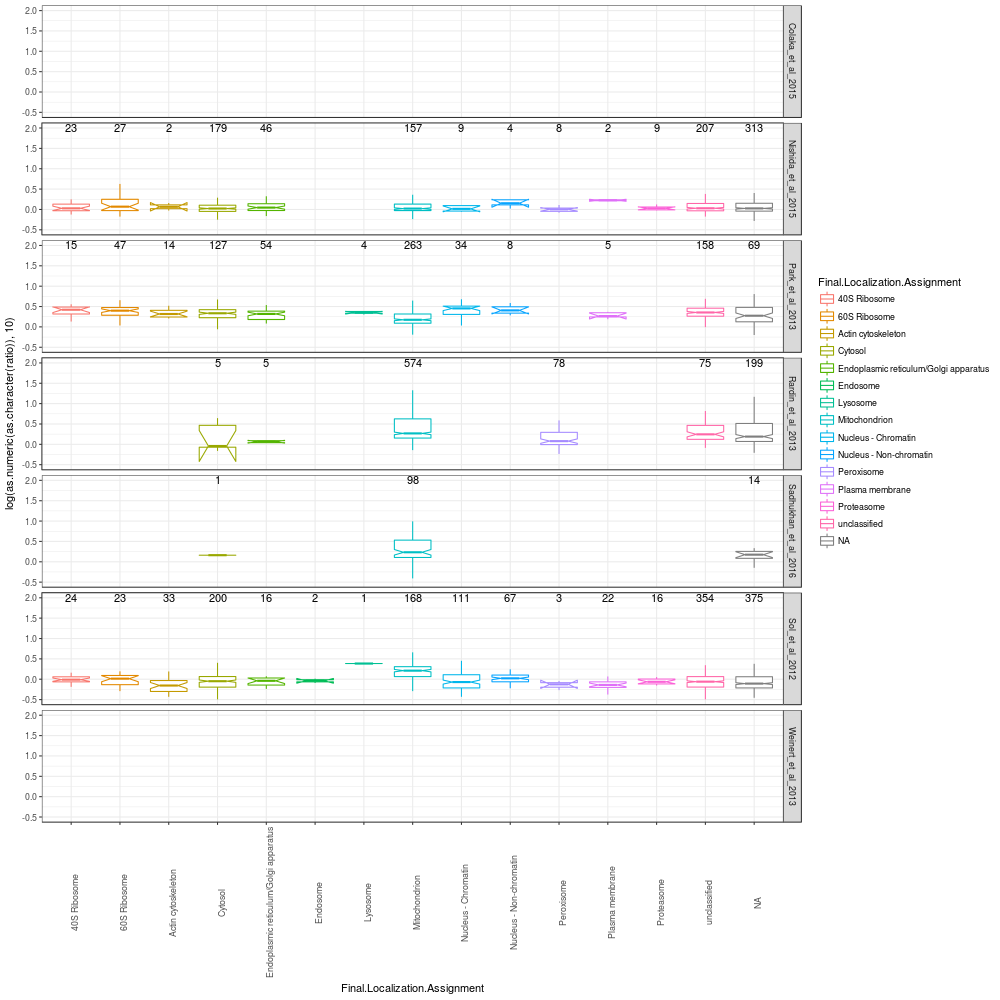

In [35]:
%%R -w 1000 -h 1000
print(head(final_df_full))
print(unique(final_df_full$'Final.Localization.Assignment'))
keep_localistions = c("Nucleus - Chromatin", "Mitochondrion")

tmp_df = final_df_full
#tmp_df = tmp_df[tmp_df[['Final.Localization.Assignment']] %in% keep_localistions,]

p = ggplot(tmp_df,
           aes(Final.Localization.Assignment, log(as.numeric(as.character(ratio)), 10),
               colour=Final.Localization.Assignment)) +
geom_boxplot(notch=T, outlier.size=NA) + theme_bw()  +
facet_grid(reference ~ .) +
stat_summary(fun.data = give.n, geom = "text", colour='black') +
ylim(-0.5, 2) +
theme(axis.text.x=element_text(angle=90))

print(p)

In [36]:
%%R
print(dim(tmp_df[tmp_df$reference=='Colaka_et_al_2015',]))
print(dim(tmp_df[tmp_df$reference=='Sadhukhan_et_al_2016',]))

[1] 3381   10
[1] 115  10


In [37]:
print(ratio_idr_df.columns)

Index(['uniprot_id', 'position', 'modification', 'reference', 'ratio',
       'p_value', 'in_idr'],
      dtype='object')


In [38]:
hyperlopit_inf = '~/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv'
hyperlopit_df = pd.read_table(hyperlopit_inf, sep='\t')
hyperlopit_df = hyperlopit_df[['uniprot.accession', 'Final.Localization.Assignment']]
final_df_full2 = pd.merge(ratio_idr_df, hyperlopit_df, left_on='uniprot_id', right_on='uniprot.accession', how='left')
final_df_full2['Final.Localization.Assignment'] = final_df_full2['Final.Localization.Assignment'].fillna("Not_covered")
print(final_df_full2.head())

  uniprot_id position  modification           reference             ratio  \
0     A0JNU3      354  malonylation   Colaka_et_al_2015                -1   
1     A2A432      676  malonylation   Colaka_et_al_2015                -1   
2     A2A432      846  malonylation   Colaka_et_al_2015                -1   
3     A2A791     1439   acetylation      Sol_et_al_2012              0.90   
4     A2A791      736  malonylation  Nishida_et_al_2015  1.03212287786759   

  p_value in_idr uniprot.accession Final.Localization.Assignment  
0      -1  False               NaN                   Not_covered  
1      -1  False            A2A432                  unclassified  
2      -1  False            A2A432                  unclassified  
3      -1   True            A2A791           Nucleus - Chromatin  
4   0.897  False            A2A791           Nucleus - Chromatin  


In [39]:
print(final_df_full2.head())

print(final_df_full2.shape)

print(collections.Counter(final_df_full2['Final.Localization.Assignment']))
print(sum(collections.Counter(final_df_full2['Final.Localization.Assignment']).values()))

print(final_df_full2.groupby(
        ['reference', 'modification'])['uniprot_id'].count().to_string())
print(final_df_full2.groupby(
        ['reference', 'modification'])['uniprot_id'].nunique().to_string())
print(final_df_full2.groupby(
        ['reference', 'modification', 'Final.Localization.Assignment'])['uniprot_id'].nunique().to_string())

  uniprot_id position  modification           reference             ratio  \
0     A0JNU3      354  malonylation   Colaka_et_al_2015                -1   
1     A2A432      676  malonylation   Colaka_et_al_2015                -1   
2     A2A432      846  malonylation   Colaka_et_al_2015                -1   
3     A2A791     1439   acetylation      Sol_et_al_2012              0.90   
4     A2A791      736  malonylation  Nishida_et_al_2015  1.03212287786759   

  p_value in_idr uniprot.accession Final.Localization.Assignment  
0      -1  False               NaN                   Not_covered  
1      -1  False            A2A432                  unclassified  
2      -1  False            A2A432                  unclassified  
3      -1   True            A2A791           Nucleus - Chromatin  
4   0.897  False            A2A791           Nucleus - Chromatin  
(12888, 9)
Counter({'Mitochondrion': 3505, 'Not_covered': 3351, 'unclassified': 2441, 'Cytosol': 1503, 'Endoplasmic reticulum/Golgi app

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/

  uniprot_id position modification          reference     ratio p_value in_idr
1     A0JNU3      354 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
2     A2A432      846 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
3     A2A432      676 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
4     A2A791      736 malonylation Nishida_et_al_2015  1.032123   0.897  FALSE
5     A2A791     1439  acetylation     Sol_et_al_2012  0.900000      -1   TRUE
6     A2A8U2      133 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
   label1                label2 Final.Localization.Assignment
1  Colaka  malonylation\nColaka                          <NA>
2  Colaka  malonylation\nColaka                  unclassified
3  Colaka  malonylation\nColaka                  unclassified
4 Nishida malonylation\nNishida           Nucleus - Chromatin
5     Sol      acetylation\nSol           Nucleus - Chromatin
6  Colaka  malonylation\nColaka                          <NA>
[1] 12888    

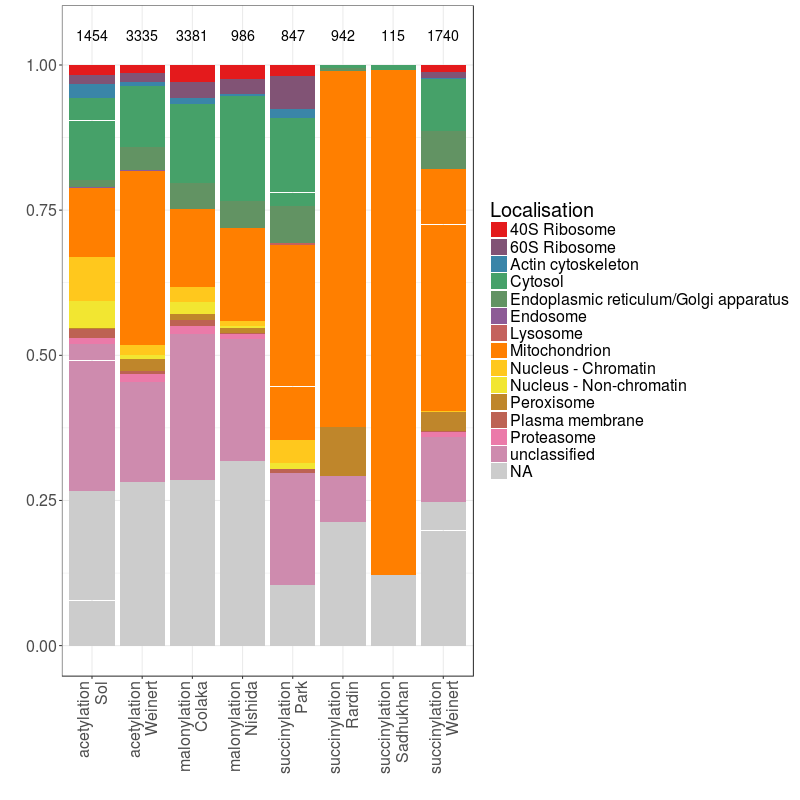

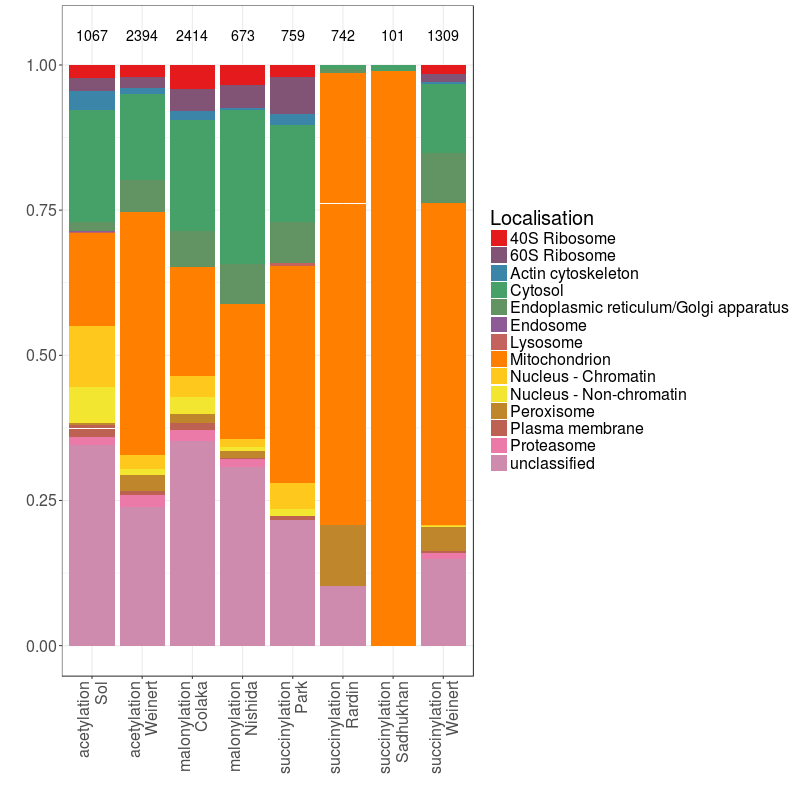

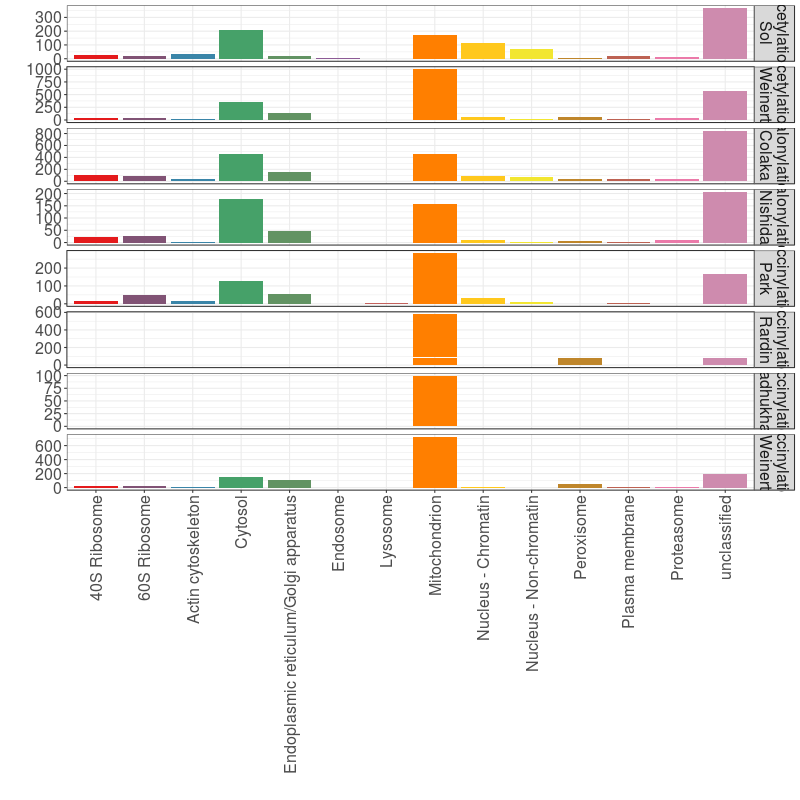

In [40]:
%%R -w 800 -h 800
library(RColorBrewer)
library(dplyr)

m_txt = element_text(size=20)
my_theme = theme(
text=m_txt)


print(head(final_df_full))
tmp_df <- final_df_full
print(dim(tmp_df))

tmp_df <- tmp_df[tmp_df[['modification']]!='succinylation_SIRT5_KO',]
    


#sapply(strsplit(rownames(my_data),split= "\\."),'[',1)
print(dim(tmp_df))
print(head(tmp_df))

colourCount = length(unique(tmp_df[['Final.Localization.Assignment']]))
getPalette = colorRampPalette(brewer.pal(9, "Set1"))

totals = data.frame(table(tmp_df$label2))

p = ggplot(tmp_df, aes(x=label2, y=1, fill=Final.Localization.Assignment)) +
geom_bar(stat='identity',position = "fill") +
geom_text(aes(Var1, 1.05, label = Freq, fill = NULL), data = totals, size=5) +
theme_bw() +
my_theme +
scale_fill_manual("Localisation", values=getPalette(colourCount), na.value='grey80') +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
xlab("") + ylab("")

print(p)

ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_localisation_1.png',
      width = 10, height=10, dpi = 600)

tmp_df <- tmp_df[!is.na(tmp_df[['Final.Localization.Assignment']]),]
totals = data.frame(table(tmp_df$label2))

p = ggplot(tmp_df, aes(x=label2, y=1, fill=Final.Localization.Assignment)) +
geom_bar(stat='identity',position = "fill") +
geom_text(aes(Var1, 1.05, label = Freq, fill = NULL), data = totals, size=5) +
theme_bw() +
my_theme +
scale_fill_manual("Localisation", values=getPalette(colourCount), na.value='grey80') +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
xlab("") + ylab("")

print(p)

ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_localisation_2.png',
      width = 10, height=10, dpi = 600)




tmp_df <- tmp_df[tmp_df[['modification']]!='succinylation_SIRT5_KO',]

p = ggplot(tmp_df, aes(x=Final.Localization.Assignment, y=1, fill=Final.Localization.Assignment)) +
geom_bar(stat='identity') +
theme_bw() +
my_theme +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
xlab("") + ylab("") +
facet_grid(label2~., scales='free') +
scale_fill_manual(guide=F, values=getPalette(colourCount))

print(p)

print(table(tmp_df[['Final.Localization.Assignment']]))

In [41]:
%%R
give.n1 <- function(x){
   return(c(y = -4, label = length(x)))
}



In [42]:
%%R -w 800 -h 800
library(beeswarm)
print(head(final_df_full))
print(unique(final_df_full$'Final.Localization.Assignment'))
keep_localistions = c("40S Ribosome", "60S Ribosome", "Mitochondrion", "Cytosol",
                      "unclassified", "Peroxisome", NA)

tmp_df = final_df_full
print(dim(tmp_df))
tmp_df = tmp_df[tmp_df$ratio!=-1,]
print(dim(tmp_df))
print(unique(tmp_df[['Final.Localization.Assignment']]))
tmp_df = tmp_df[tmp_df[['Final.Localization.Assignment']] %in% keep_localistions,]
print(dim(tmp_df))
#tmp_df = tmp_df[!(tmp_df[['Final.Localization.Assignment']]=='Cytosol' &
#                  tmp_df[['reference']]=='Rardin_et_al_2013'),]
#tmp_df = tmp_df[!(tmp_df[['Final.Localization.Assignment']] == "Peroxisome" &
#                  tmp_df[['reference']]=='Nishida_et_al_2015'),]

m_txt = element_text(size=20)
my_theme = theme(
text=m_txt)

my.fun<-function(x){data.frame(ymin=mean(x)-(sd(x, na.rm=TRUE) / sqrt(length(x[!is.na(x)])-1)),
                               ymax=mean(x)+(sd(x, na.rm=TRUE) / sqrt(length(x[!is.na(x)])-1)),
                               y=mean(x))}

#my.fun<-function(x){data.frame(ymin=median(x),
#                               ymax==median(x),
#                               y=median(x))}





p = ggplot(tmp_df[tmp_df$in_idr==F,],
           aes(Final.Localization.Assignment, log(ratio, 2), colour=Final.Localization.Assignment)) +
geom_quasirandom(size=1) + 
facet_grid(label2 ~ ., scales='free') +
stat_summary(fun.data = give.n1, geom = "text", colour='black', size=5) +
#stat_summary(fun.data = my.fun, geom = "pointrange", colour='black', size=0.5) +
scale_colour_discrete(guide=F) +
theme_bw() +
my_theme +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
coord_cartesian() + 
xlab("") + ylab("Log2 Ratio WT vs SIRT -/- KO")

print(p)

ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/sirt_ratio_localisation.png',
      width = 10, height=10, dpi = 600)


p = ggplot(tmp_df[tmp_df$in_idr==F,],
           aes(label2, log(ratio, 2), colour=label2)) +
geom_quasirandom(size=1) + 
facet_grid(Final.Localization.Assignment ~ ., scales='free') +
stat_summary(fun.data = give.n1, geom = "text", colour='black', size=5) +
#stat_summary(fun.data = my.fun, geom = "pointrange", colour='black', size=0.5) +
scale_colour_discrete(guide=F) +
theme_bw() +
my_theme +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
coord_cartesian() + #ylim=c(-1.5,4.5)) +
xlab("") + ylab("Log2 Ratio WT vs SIRT -/- KO")

print(p)


p = ggplot(tmp_df[tmp_df$in_idr==F,],
           aes(Final.Localization.Assignment, log(ratio, 2), colour=Final.Localization.Assignment)) +
facet_grid(label2 ~ ., scales='free') +
geom_boxplot() +
scale_colour_discrete(guide=F) +
theme_bw() +
my_theme +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
coord_cartesian() + #ylim=c(-1.5,4.5)) +
xlab("") + ylab("Log2 Ratio WT vs SIRT -/- KO")

print(p)



p = ggplot(tmp_df[tmp_df$in_idr==F,],
           aes(label2, log(ratio, 2), colour=label2)) +
facet_grid(Final.Localization.Assignment ~ ., scales='free') +
geom_boxplot() +
scale_colour_discrete(guide=F) +
theme_bw() +
my_theme +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
coord_cartesian() + #ylim=c(-1.5,4.5)) +
xlab("") + ylab("Log2 Ratio WT vs SIRT -/- KO")

print(p)

  uniprot_id position modification          reference     ratio p_value in_idr
1     A0JNU3      354 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
2     A2A432      846 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
3     A2A432      676 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
4     A2A791      736 malonylation Nishida_et_al_2015  1.032123   0.897  FALSE
5     A2A791     1439  acetylation     Sol_et_al_2012  0.900000      -1   TRUE
6     A2A8U2      133 malonylation  Colaka_et_al_2015 -1.000000      -1  FALSE
   label1                label2 Final.Localization.Assignment
1  Colaka  malonylation\nColaka                          <NA>
2  Colaka  malonylation\nColaka                  unclassified
3  Colaka  malonylation\nColaka                  unclassified
4 Nishida malonylation\nNishida           Nucleus - Chromatin
5     Sol      acetylation\nSol           Nucleus - Chromatin
6  Colaka  malonylation\nColaka                          <NA>
 [1] <NA>    

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : could not find function "geom_quasirandom"

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface

In [43]:
%%R

tmp_df = final_df_full
tmp_df = tmp_df[tmp_df$ratio!=-1,]
tmp_df = tmp_df[tmp_df[['Final.Localization.Assignment']] %in% keep_localistions,]

print(head(tmp_df))

for (reference in unique(tmp_df[['reference']])){
        print(reference)
        tmp_df2 = tmp_df[tmp_df[['reference']] == reference,]
        Mt_ratios = tmp_df2$ratio[tmp_df2[['Final.Localization.Assignment']]=='Mitochondrion']
        Mt_ratios = Mt_ratios[is.finite(Mt_ratios)]

    for (localisation in unique(tmp_df2[['Final.Localization.Assignment']])){
        if (!is.na(localisation)){
        print(localisation)
        other_ratios = tmp_df2$ratio[tmp_df2[['Final.Localization.Assignment']]==localisation]
        other_ratios = other_ratios[is.finite(other_ratios)]
        
        print(mean(Mt_ratios))
        print(mean(other_ratios))
            
        print(wilcox.test(Mt_ratios, other_ratios))
        print("")
        }
    }
}

   uniprot_id position  modification         reference ratio p_value in_idr
7      A2A8Z1      645   acetylation    Sol_et_al_2012  0.88      -1  FALSE
10     A2AJT4      730   acetylation    Sol_et_al_2012  0.80      -1   TRUE
11     A2AKK5      305 succinylation Rardin_et_al_2013  1.52 4.8E-02  FALSE
14     A2AN08     3813   acetylation    Sol_et_al_2012  1.15      -1  FALSE
15     A2AQ19      418   acetylation    Sol_et_al_2012  1.63      -1  FALSE
19     A2AS89      223 succinylation Rardin_et_al_2013  1.18 3.9E-01  FALSE
   label1                label2 Final.Localization.Assignment
7     Sol      acetylation\nSol                  unclassified
10    Sol      acetylation\nSol                          <NA>
11 Rardin succinylation\nRardin                          <NA>
14    Sol      acetylation\nSol                          <NA>
15    Sol      acetylation\nSol                  unclassified
19 Rardin succinylation\nRardin                          <NA>
[1] "Sol_et_al_2012"
[1] "unclassi

In [44]:
%%R
give.n2 <- function(x){
   return(c(y = 3, label = length(x)))
}

give.n3 <- function(x){
   return(c(y = -3, label = length(x)))
}

In [45]:
%%R
library(ggbeeswarm)

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


[1] 12888     9
[1] 12888    10


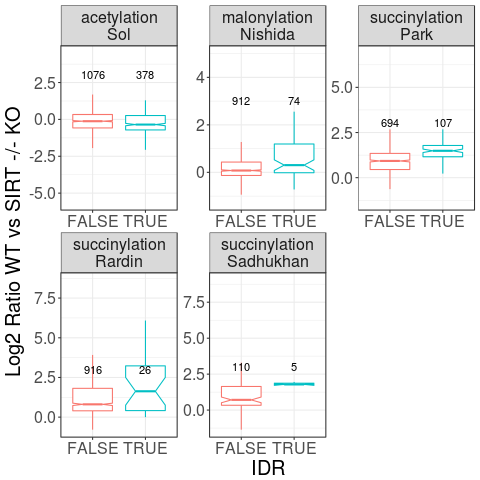

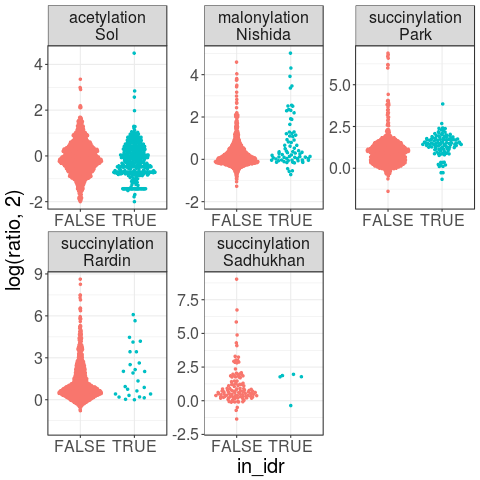

In [46]:
%%R

print(dim(ratio_idr_df))

ratio_idr_df <- merge(
    ratio_idr_df, hyperlopit_df, by.x='uniprot_id', by.y='uniprot.accession', all.x=TRUE)

print(dim(ratio_idr_df))

m_txt = element_text(size=20)
my_theme = theme(
text=m_txt)

#ratio_idr_noPark_nominal_sig = ratio_idr_df[ratio_idr_noPark$p_value<0.01,]
ratio_idr_noNA = ratio_idr_df
ratio_idr_noNA = ratio_idr_noNA[!is.na(ratio_idr_noNA$in_idr),]
ratio_idr_noNA = ratio_idr_noNA[ratio_idr_noNA$ratio!=-1,]

           
p = ggplot(ratio_idr_noNA, aes(in_idr, log(ratio,2), colour=in_idr)) +
geom_boxplot(notch=T, outlier.size=NA) + theme_bw()  + facet_wrap(~label2, scales='free') +
stat_summary(fun.data = give.n2, geom = "text", colour='black') +
scale_colour_discrete(guide=F) +
xlab("IDR") + ylab("Log2 Ratio WT vs SIRT -/- KO") +
my_theme

print(p)

ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_ratio_sirt5_idr_1.png',
       width = 10, height=10, dpi = 600)


p = ggplot(ratio_idr_noNA, aes(in_idr, log(ratio, 2), colour=in_idr)) +
theme_bw()  + facet_wrap(~label2, scales='free') +
geom_quasirandom(size=1) + 
stat_summary(fun.data = give.n3, geom = "text", colour='black') +
scale_colour_discrete(guide=F) +
ylim(-2, NA) +
my_theme

print(p)

ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_ratio_sirt5_idr_2.png',
       width = 10, height=10, dpi = 600)


In [47]:
%%R

print(head(ratio_idr_noNA[ratio_idr_noNA$label1=='Sol',]))

   uniprot_id position modification      reference ratio p_value in_idr label1
5      A2A791     1439  acetylation Sol_et_al_2012  0.90      -1   TRUE    Sol
7      A2A8Z1      645  acetylation Sol_et_al_2012  0.88      -1  FALSE    Sol
10     A2AJT4      730  acetylation Sol_et_al_2012  0.80      -1   TRUE    Sol
14     A2AN08     3813  acetylation Sol_et_al_2012  1.15      -1  FALSE    Sol
15     A2AQ19      418  acetylation Sol_et_al_2012  1.63      -1  FALSE    Sol
28     A2BH40     1903  acetylation Sol_et_al_2012  0.88      -1   TRUE    Sol
             label2 Final.Localization.Assignment
5  acetylation\nSol           Nucleus - Chromatin
7  acetylation\nSol                  unclassified
10 acetylation\nSol                          <NA>
14 acetylation\nSol                          <NA>
15 acetylation\nSol                  unclassified
28 acetylation\nSol           Nucleus - Chromatin


In [48]:
%%R -i ratio_idr_df
print(head(hyperlopit_df))
print(head(ratio_idr_df))
print(dim(ratio_idr_df))
ratio_idr_df <- merge(
    ratio_idr_df, hyperlopit_df, by.x='uniprot_id', by.y='uniprot.accession', all.x=TRUE)
print(dim(ratio_idr_df))

  uniprot.accession Final.Localization.Assignment
1            Q9JHU4                  unclassified
2            Q9ERU9           Nucleus - Chromatin
3            P26039            Actin cytoskeleton
4            Q8BTM8                  unclassified
5            A2ARV4                  unclassified
6            Q80X90                  unclassified
  uniprot_id position modification          reference            ratio p_value
0     A0JNU3      354 malonylation  Colaka_et_al_2015               -1      -1
1     A2A432      676 malonylation  Colaka_et_al_2015               -1      -1
2     A2A432      846 malonylation  Colaka_et_al_2015               -1      -1
3     A2A791     1439  acetylation     Sol_et_al_2012             0.90      -1
4     A2A791      736 malonylation Nishida_et_al_2015 1.03212287786759   0.897
5     A2A8U2      133 malonylation  Colaka_et_al_2015               -1      -1
  in_idr
0  FALSE
1  FALSE
2  FALSE
3   TRUE
4  FALSE
5  FALSE
[1] 12888     7
[1] 12888     8


  uniprot_id position modification          reference            ratio p_value
1     A0JNU3      354 malonylation  Colaka_et_al_2015               -1      -1
2     A2A432      846 malonylation  Colaka_et_al_2015               -1      -1
3     A2A432      676 malonylation  Colaka_et_al_2015               -1      -1
4     A2A791      736 malonylation Nishida_et_al_2015 1.03212287786759   0.897
5     A2A791     1439  acetylation     Sol_et_al_2012             0.90      -1
6     A2A8U2      133 malonylation  Colaka_et_al_2015               -1      -1
  in_nls  label1                label2 Final.Localization.Assignment
1  FALSE  Colaka  malonylation\nColaka                          <NA>
2  FALSE  Colaka  malonylation\nColaka                  unclassified
3  FALSE  Colaka  malonylation\nColaka                  unclassified
4  FALSE Nishida malonylation\nNishida           Nucleus - Chromatin
5  FALSE     Sol      acetylation\nSol           Nucleus - Chromatin
6  FALSE  Colaka  malonylation\nC

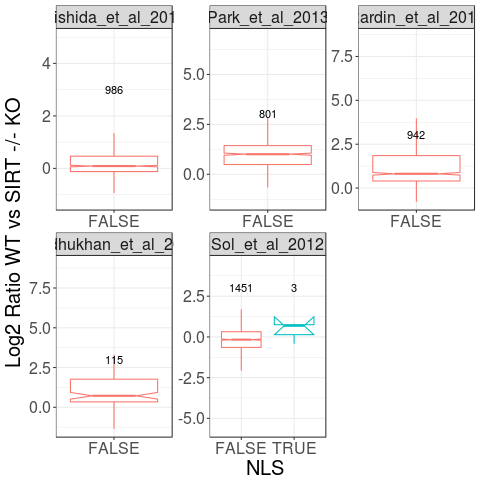

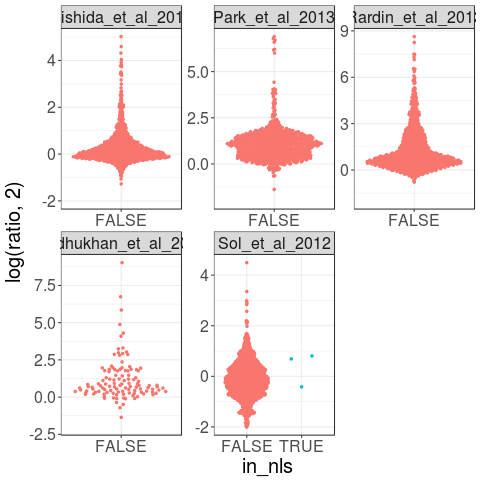

In [49]:
%%R -i ratio_nls_df

ratio_nls_df$label1 <- sapply(strsplit(as.character(ratio_nls_df$reference), "_", fixed=T),'[',1)
ratio_nls_df$label2 <- paste0(ratio_nls_df$modification, "\n", ratio_nls_df$label1)


ratio_nls_df <- merge(
    ratio_nls_df, hyperlopit_df, by.x='uniprot_id', by.y='uniprot.accession', all.x=TRUE)

print(head(ratio_nls_df))
m_txt = element_text(size=20)
my_theme = theme(
text=m_txt)

#ratio_idr_noPark_nominal_sig = ratio_idr_df[ratio_idr_noPark$p_value<0.01,]
ratio_nls_noNA = ratio_nls_df
ratio_nls_noNA = ratio_nls_noNA[!is.na(ratio_nls_noNA$in_nls),]
ratio_nls_noNA = ratio_nls_noNA[ratio_nls_noNA$ratio!=-1,]

print(head(ratio_nls_noNA))
ratio_nls_noNA$ratio = as.numeric(as.character(ratio_nls_noNA$ratio))
           
p = ggplot(ratio_nls_noNA, aes(in_nls, log(ratio,2), colour=in_nls)) +
geom_boxplot(notch=T, outlier.size=NA) + theme_bw()  + 
facet_wrap(~reference, scales='free') +
stat_summary(fun.data = give.n2, geom = "text", colour='black') +
scale_colour_discrete(guide=F) +
xlab("NLS") + ylab("Log2 Ratio WT vs SIRT -/- KO") +
my_theme

print(p)

#ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_ratio_sirt5_nls_1.png',
#       width = 10, height=10, dpi = 600)


p = ggplot(ratio_nls_noNA, aes(in_nls, log(ratio, 2), colour=in_nls)) +
theme_bw()  + facet_wrap(~reference, scales='free') +
geom_quasirandom(size=1) + 
stat_summary(fun.data = give.n3, geom = "text", colour='black') +
scale_colour_discrete(guide=F) +
ylim(-2, NA) +
my_theme

print(p)

#ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_ratio_sirt5_nls_2.png',
#       width = 10, height=10, dpi = 600)


In [50]:
%%R
print(head(ratio_idr_noNA))

for (reference in unique(ratio_idr_noNA[['reference']])){
    print(reference)
    tmp_df = ratio_idr_noNA[ratio_idr_noNA$reference == reference,]
    idr_ratios = tmp_df[tmp_df['in_idr']==T, 'ratio']
    non_idr_ratios = tmp_df[tmp_df['in_idr']==F, 'ratio']
    print(median(idr_ratios))
    print(median(non_idr_ratios))
    print(wilcox.test(idr_ratios, non_idr_ratios))
}


   uniprot_id position  modification          reference    ratio p_value in_idr
4      A2A791      736  malonylation Nishida_et_al_2015 1.032123   0.897  FALSE
5      A2A791     1439   acetylation     Sol_et_al_2012 0.900000      -1   TRUE
7      A2A8Z1      645   acetylation     Sol_et_al_2012 0.880000      -1  FALSE
10     A2AJT4      730   acetylation     Sol_et_al_2012 0.800000      -1   TRUE
11     A2AKK5      305 succinylation  Rardin_et_al_2013 1.520000 4.8E-02  FALSE
14     A2AN08     3813   acetylation     Sol_et_al_2012 1.150000      -1  FALSE
    label1                label2 Final.Localization.Assignment
4  Nishida malonylation\nNishida           Nucleus - Chromatin
5      Sol      acetylation\nSol           Nucleus - Chromatin
7      Sol      acetylation\nSol                  unclassified
10     Sol      acetylation\nSol                          <NA>
11  Rardin succinylation\nRardin                          <NA>
14     Sol      acetylation\nSol                          <NA>

  uniprot_id position modification          reference            ratio p_value
1     A0JNU3      354 malonylation  Colaka_et_al_2015               -1      -1
2     A2A432      846 malonylation  Colaka_et_al_2015               -1      -1
3     A2A432      676 malonylation  Colaka_et_al_2015               -1      -1
4     A2A791      736 malonylation Nishida_et_al_2015 1.03212287786759   0.897
5     A2A791     1439  acetylation     Sol_et_al_2012             0.90      -1
6     A2A8U2      133 malonylation  Colaka_et_al_2015               -1      -1
  in_krepeats len_repeats Final.Localization.Assignment  label1
1       FALSE           1                          <NA>  Colaka
2       FALSE           1                  unclassified  Colaka
3       FALSE           1                  unclassified  Colaka
4       FALSE           1           Nucleus - Chromatin Nishida
5       FALSE           1           Nucleus - Chromatin     Sol
6       FALSE           1                          <NA>  Colaka

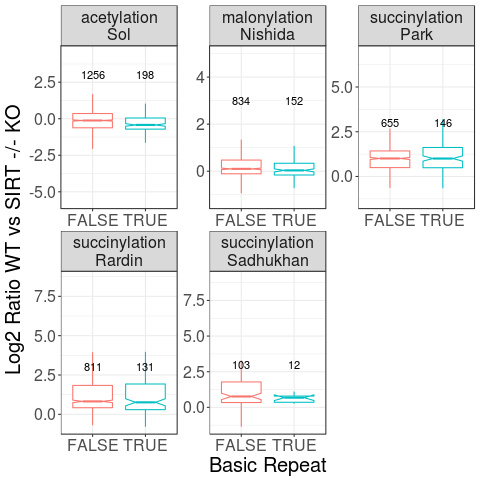

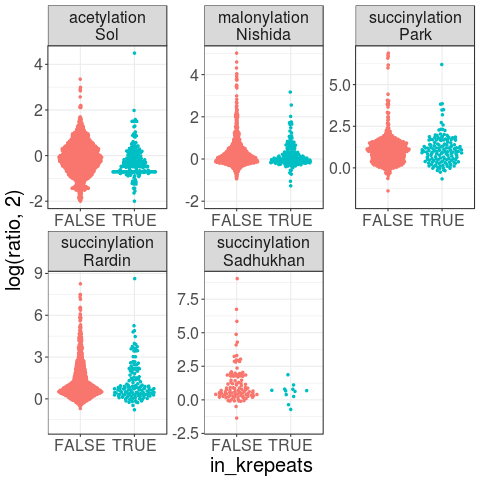

In [51]:
%%R -i ratio_krepeats_df

ratio_krepeats_df <- merge(
    ratio_krepeats_df, hyperlopit_df, by.x='uniprot_id', by.y='uniprot.accession', all.x=TRUE)

ratio_krepeats_df$label1 <- sapply(strsplit(as.character(ratio_krepeats_df$reference), "_", fixed=T),'[',1)
ratio_krepeats_df$label2 <- paste0(ratio_krepeats_df$modification, "\n", ratio_krepeats_df$label1)


print(head(ratio_krepeats_df))
m_txt = element_text(size=20)
my_theme = theme(
text=m_txt)

#ratio_idr_noPark_nominal_sig = ratio_idr_df[ratio_idr_noPark$p_value<0.01,]
ratio_krepeats_noNA = ratio_krepeats_df
ratio_krepeats_noNA = ratio_krepeats_noNA[!is.na(ratio_krepeats_noNA$in_krepeats),]
ratio_krepeats_noNA = ratio_krepeats_noNA[ratio_krepeats_noNA$ratio!=-1,]
ratio_krepeats_noNA$ratio = as.numeric(as.character(ratio_krepeats_noNA$ratio))

ratio_krepeats_noNA$ratio = as.numeric(as.character(ratio_krepeats_noNA$ratio))
           
p = ggplot(ratio_krepeats_noNA, aes(in_krepeats, log(ratio,2), colour=in_krepeats)) +
geom_boxplot(notch=T, outlier.size=NA) + theme_bw()  + 
facet_wrap(~label2, scales='free') +
stat_summary(fun.data = give.n2, geom = "text", colour='black') +
scale_colour_discrete(guide=F) +
xlab("Basic Repeat") + ylab("Log2 Ratio WT vs SIRT -/- KO") +
my_theme

print(p)

#ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_ratio_sirt5_nls_1.png',
#       width = 10, height=10, dpi = 600)


p = ggplot(ratio_krepeats_noNA, aes(in_krepeats, log(ratio, 2), colour=in_krepeats)) +
theme_bw()  + facet_wrap(~label2, scales='free') +
geom_quasirandom(size=1) + 
stat_summary(fun.data = give.n3, geom = "text", colour='black') +
scale_colour_discrete(guide=F) +
ylim(-2, NA) +
my_theme

print(p)

#ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_ratio_sirt5_nls_2.png',
#       width = 10, height=10, dpi = 600)


In [52]:
%%R
tmp_df <- ratio_krepeats_noNA#[ratio_krepeats_noNA$label1=='Park',]
tmp_df <- tmp_df[tmp_df['uniprot_id']=='Q91V76',]
print(tmp_df[order(tmp_df$position),])



     uniprot_id position modification          reference    ratio p_value
9046     Q91V76      215 malonylation Nishida_et_al_2015 1.501067    0.14
9040     Q91V76      307 malonylation Nishida_et_al_2015 2.286085 0.00059
     in_krepeats len_repeats Final.Localization.Assignment  label1
9046       FALSE           1                       Cytosol Nishida
9040       FALSE           1                       Cytosol Nishida
                    label2
9046 malonylation\nNishida
9040 malonylation\nNishida


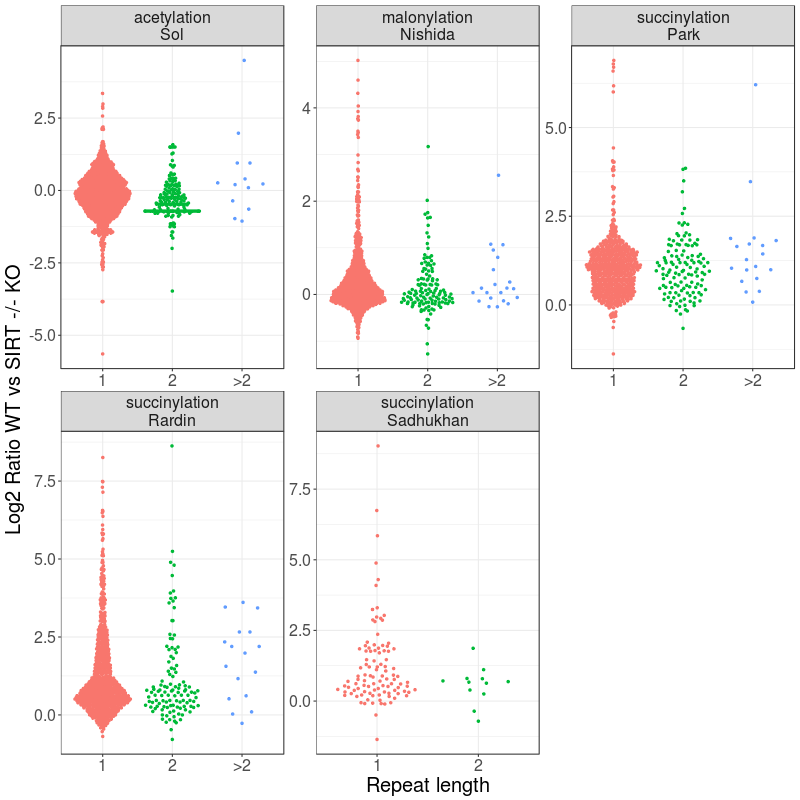

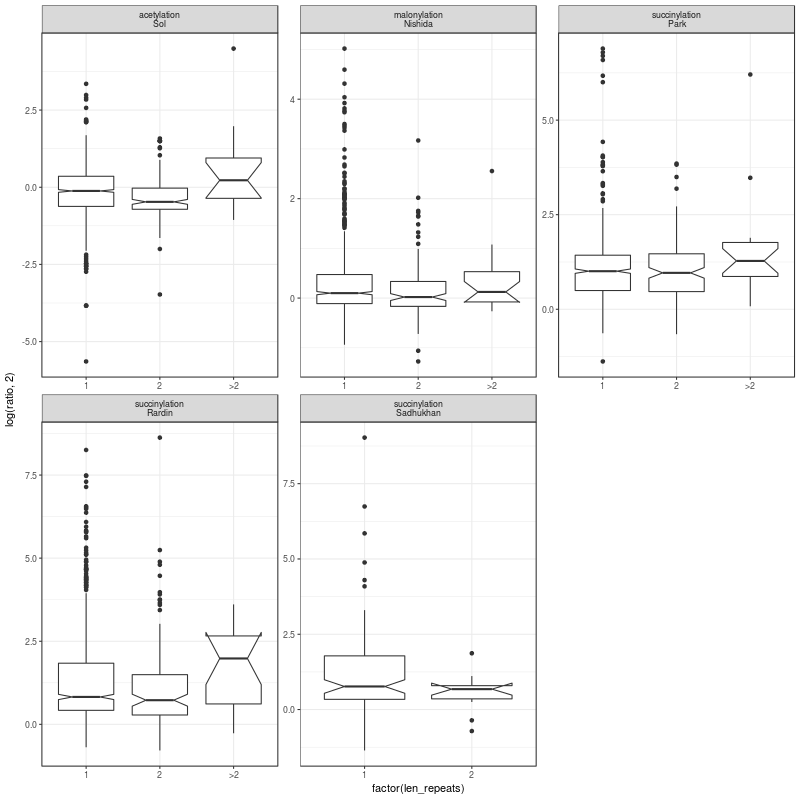

In [53]:
%%R -w 800 -h 800
m_txt = element_text(size=20)
my_theme = theme(
text=m_txt)

ratio_krepeats_noNA <- ratio_krepeats_noNA[!ratio_krepeats_noNA['len_repeats']=='NaN',]

final_ratio_krepeats <- ratio_krepeats_noNA
final_ratio_krepeats[['len_repeats']][final_ratio_krepeats[['len_repeats']]>2] <- ">2"
final_ratio_krepeats[['len_repeats']] <- factor(final_ratio_krepeats[['len_repeats']],
                                               levels=c(1,2, ">2"))
p <- ggplot(final_ratio_krepeats,
            aes(len_repeats, log(ratio, 2), colour=len_repeats)) + 
geom_quasirandom(size=1) +
scale_colour_discrete(guide=F) +
facet_wrap(~label2, scales='free') +
theme_bw() +
ylab("Log2 Ratio WT vs SIRT -/- KO") + xlab("Repeat length") +
my_theme

print(p)

ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/study_ratio_sirt5_repeats.png',
       width = 10, height=10, dpi = 600)

p <- ggplot(final_ratio_krepeats,
            aes(factor(len_repeats), log(ratio, 2))) + 
geom_boxplot(notch=TRUE) +
facet_wrap(~label2, scales='free') +
theme_bw()

print(p)

In [54]:
%%R

for (reference in unique(final_ratio_krepeats[['reference']])){
    print(reference)
    tmp_df = final_ratio_krepeats[final_ratio_krepeats$reference == reference,]
    repeat_ratios = tmp_df[tmp_df['len_repeats']==1, 'ratio']
    repeat2_ratios = tmp_df[tmp_df['len_repeats']==2, 'ratio']
    non_repeat_ratios = tmp_df[tmp_df['len_repeats']=='>2', 'ratio']
    print(median(repeat_ratios))
    print(median(repeat2_ratios))
    print(median(non_repeat_ratios))
    print(wilcox.test(repeat_ratios, repeat2_ratios))
    print(wilcox.test(repeat2_ratios, non_repeat_ratios))
}


[1] "Nishida_et_al_2015"
[1] 1.071268
[1] 1.014504
[1] 1.089719

	Wilcoxon rank sum test with continuity correction

data:  repeat_ratios and repeat2_ratios
W = 60766, p-value = 0.03846
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  repeat2_ratios and non_repeat_ratios
W = 1167, p-value = 0.2667
alternative hypothesis: true location shift is not equal to 0

[1] "Sol_et_al_2012"
[1] 0.92
[1] 0.72
[1] 1.17

	Wilcoxon rank sum test with continuity correction

data:  repeat_ratios and repeat2_ratios
W = 138960, p-value = 1.624e-05
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  repeat2_ratios and non_repeat_ratios
W = 703.5, p-value = 0.01226
alternative hypothesis: true location shift is not equal to 0

[1] "Rardin_et_al_2013"
[1] 1.77
[1] 1.655
[1] 3.95

	Wilcoxon rank sum test with continuity correction

data:  repeat_ratios and repeat2_r

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in wilcox.test.default(repeat2_ratios, non_repeat_ratios) : 
  not enough 'y' observations

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: There were 12 warnings (use warnings() to see them)
  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


In [55]:
%%R
n <- count.fields(hyperlopit_inf, sep='\t', blank.lines.skip=FALSE)
hyperlopit_inf = '~/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv'
hyperlopit_df = read.table(hyperlopit_inf, sep='\t', header=T, quote = "", comment.char = "")
print(dim(hyperlopit_df))

hyperlopit_df <- hyperlopit_df[,c('uniprot.accession', 'Final.Localization.Assignment')]
print(head(hyperlopit_df))
print(dim(hyperlopit_df))

final_df_full = merge(ratio_idr_df, hyperlopit_df,
                      by.x='uniprot_id', by.y='uniprot.accession', all.x=TRUE)

[1] 4413   94
  uniprot.accession Final.Localization.Assignment
1            Q9JHU4                  unclassified
2            Q9ERU9           Nucleus - Chromatin
3            P26039            Actin cytoskeleton
4            Q8BTM8                  unclassified
5            A2ARV4                  unclassified
6            Q80X90                  unclassified
[1] 4413    2


  uniprot_id position modification          reference            ratio p_value
1     A0JNU3      354 malonylation  Colaka_et_al_2015               -1      -1
2     A2A432      846 malonylation  Colaka_et_al_2015               -1      -1
3     A2A432      676 malonylation  Colaka_et_al_2015               -1      -1
4     A2A791      736 malonylation Nishida_et_al_2015 1.03212287786759   0.897
5     A2A791     1439  acetylation     Sol_et_al_2012             0.90      -1
6     A2A8U2      133 malonylation  Colaka_et_al_2015               -1      -1
  in_idr Final.Localization.Assignment
1  FALSE                          <NA>
2  FALSE                  unclassified
3  FALSE                  unclassified
4  FALSE           Nucleus - Chromatin
5   TRUE           Nucleus - Chromatin
6  FALSE                          <NA>


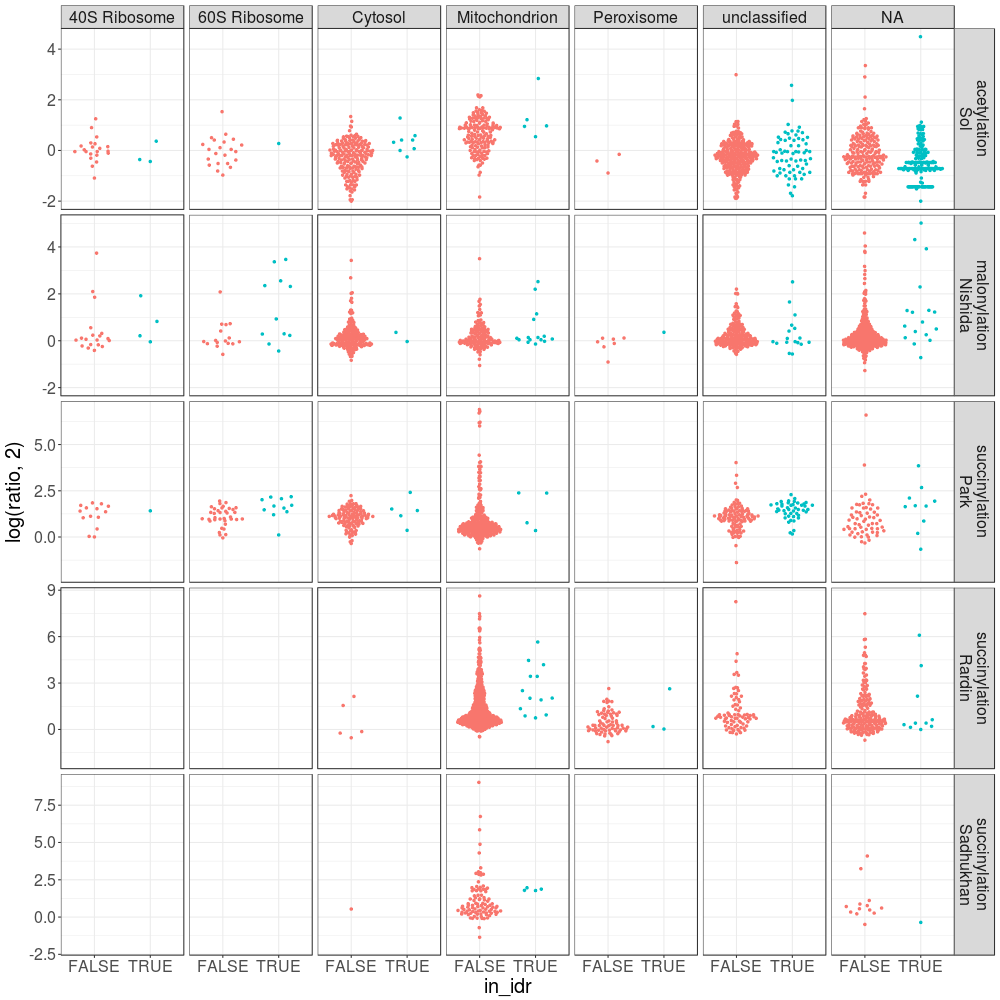

In [56]:
%%R -w 1000 -h 1000
print(head(ratio_idr_df))

keep_localistions = c("40S Ribosome", "60S Ribosome", "Mitochondrion", "Cytosol",
                      "unclassified", "Peroxisome", NA)

p = ggplot(ratio_idr_noNA[ratio_idr_noNA[['Final.Localization.Assignment']] %in% keep_localistions,],
           aes(in_idr, log(ratio, 2), colour=in_idr)) +
theme_bw()  +
facet_grid(label2 ~ Final.Localization.Assignment, scales='free') +
geom_quasirandom(size=1) + 
stat_summary(fun.data = give.n3, geom = "text", colour='black') +
scale_colour_discrete(guide=F) +
ylim(-2, NA) +
my_theme

print(p)

In [57]:
print(ratio_idr_df.head())
tmp_df = ratio_idr_df[ratio_idr_df['reference']=='Rardin_et_al_2013']
print(tmp_df.head())
print(tmp_df[tmp_df['uniprot_id']=='Q9CQR4'])


  uniprot_id position  modification           reference             ratio  \
0     A0JNU3      354  malonylation   Colaka_et_al_2015                -1   
1     A2A432      676  malonylation   Colaka_et_al_2015                -1   
2     A2A432      846  malonylation   Colaka_et_al_2015                -1   
3     A2A791     1439   acetylation      Sol_et_al_2012              0.90   
4     A2A791      736  malonylation  Nishida_et_al_2015  1.03212287786759   

  p_value in_idr  
0      -1  False  
1      -1  False  
2      -1  False  
3      -1   True  
4   0.897  False  
   uniprot_id position   modification          reference ratio  p_value in_idr
10     A2AKK5      305  succinylation  Rardin_et_al_2013  1.52  4.8E-02  False
18     A2AS89      223  succinylation  Rardin_et_al_2013  1.18  3.9E-01  False
22     A2ATU0      184  succinylation  Rardin_et_al_2013  1.51  1.6E-01  False
23     A2ATU0      554  succinylation  Rardin_et_al_2013  6.57  3.0E-03  False
24     A2ATU0      804  succ

In [58]:
conservation_df = pd.read_table("../raw/Rardin_succinylation_conservation.csv", sep="\t")
conservation_df.drop(["Protein Description", "Peptide Sequence", "Protein Name",
                      "Gene Name", "RefSeq", "RefSeq"],
                     axis=1, inplace=True)
print(conservation_df.shape)
conservation_df = conservation_df[conservation_df['Alignment']!="n/a"]
print(conservation_df.shape)
print(conservation_df.head())
print(conservation_df[conservation_df.columns[-7:]].head())

conservation_df['Ks'] = conservation_df[conservation_df.columns[-8:]].apply(
        lambda x: sum([base == "K" for base in x]), axis=1)

(1190, 11)
(1122, 11)
  Accession#  Site                       Alignment Conservation Score  \
0     Q8BH86    91  KKK-KKKKK-KKR-KK-KK-KKKK------                  0   
1     Q9WVM8    28  KRRKRRRRRKR-SR-KKR-KKKKR-----R                  2   
2     Q9WVM8    31  KKKKKKKKKKK-KK-KKE-EPPPPP----P                  1   
3     Q9WVM8    69  KQKKKKKKKKK-KK-KKK-KKKKKK----R                  1   
4     Q9WVM8   263  KKK-KKKKKKKKKKKKKKKK-KKKK-KKKK                  0   

  Danio rerio Xenopus tropicalis Gallus gallus Bos taurus Rattus norvegicus  \
0           -                  -             K          -                 K   
1           R                  -             K          K                 R   
2           P                  P             P          K                 K   
3           R                  K             K          K                 Q   
4           K                  K             K          K                 K   

  Homo sapiens Mus musculus  
0            K            K  
1   

In [59]:
import string

In [60]:
conservation_df = pd.read_table("../raw/Rardin_succinylation_conservation.csv", sep="\t")
conservation_df.drop(["Protein Description", "Peptide Sequence", "Protein Name",
                      "Gene Name", "RefSeq", "RefSeq"],
                     axis=1, inplace=True)
print(conservation_df.shape)
conservation_df = conservation_df[conservation_df['Alignment']!="n/a"]
print(conservation_df.shape)

bases_df = conservation_df[conservation_df.columns[-7:]]


conservation_df['all_species'] = bases_df.apply(
    lambda x: sum([base != "-" for base in x])==7, axis=1)

for aa in string.ascii_uppercase:
    if aa in ["B", "J", "O", "U", "X"]:
        continue
    conservation_df[aa] = bases_df.apply(
        lambda x: sum([base == aa for base in x]), axis=1)
    print(aa)
    print(sum(conservation_df[aa]))

conservation_df = conservation_df[conservation_df['all_species']==True]

print(conservation_df.shape)

conservation_df['Site'] = conservation_df['Site'].astype(int)
tmp_df['position'] = tmp_df['position'].astype(int)

conservation_df = pd.DataFrame(pd.merge(conservation_df, tmp_df,
                           left_on=['Accession#', 'Site'], right_on=['uniprot_id', 'position'],
                           how='left'))

def setToString(df, columns):
    for column in columns:
        conservation_df[column] = conservation_df[column].astype(str)    

setToString(conservation_df, ['uniprot_id', 'modification', 'reference', 'ratio', 'p_value', 'in_idr'])

def setToFloat(df, columns):
    for column in columns:
        conservation_df[column] = conservation_df[column].astype(float)    

#setToString(conservation_df, ['ratio'])

print(conservation_df.shape)

print(conservation_df.head())
print(conservation_df[conservation_df['Accession#']=='Q9CQR4'])


(1190, 11)
(1122, 11)
A
65
C
6
D
42
E
129
F
3
G
40
H
25
I
7
K
6010
L
19
M
16
N
116
P
19
Q
212
R
308
S
75
T
95
V
11
W
1
Y
5
Z
1
(704, 33)
(708, 40)
  Accession#  Site                       Alignment Conservation Score  \
0     Q9WVM8    31  KKKKKKKKKKK-KK-KKE-EPPPPP----P                  1   
1     Q9WVM8    69  KQKKKKKKKKK-KK-KKK-KKKKKK----R                  1   
2     Q9WVM8   263  KKK-KKKKKKKKKKKKKKKK-KKKK-KKKK                  0   
3     Q99K67    52  KKNNNNNNN-N-NN-QNN-NNNQNSTANNN                  4   
4     Q99K67   286  KK--KKKKKKKKKKKKK---KKKKKNNNNN                  1   

  Danio rerio Xenopus tropicalis Gallus gallus Bos taurus Rattus norvegicus  \
0           P                  P             P          K                 K   
1           R                  K             K          K                 Q   
2           K                  K             K          K                 K   
3           N                  S             Q          N                 K   
4           N      

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
%%R -i conservation_df
conservation_df <- conservation_df[conservation_df$in_idr!='nan',]
print(head(conservation_df))
conservation_df$ratio <- as.numeric(as.character(conservation_df$ratio))


  Accession. Site                      Alignment Conservation.Score Danio.rerio
1     Q9WVM8   69 KQKKKKKKKKK-KK-KKK-KKKKKK----R                  1           R
2     Q9WVM8  263 KKK-KKKKKKKKKKKKKKKK-KKKK-KKKK                  0           K
3     Q99K67   52 KKNNNNNNN-N-NN-QNN-NNNQNSTANNN                  4           N
4     Q99K67  286 KK--KKKKKKKKKKKKK---KKKKKNNNNN                  1           N
7     P61922  452 KKKKKKKKKKK-KKKKK-K-KKKKKSSSSR                  1           R
8     Q61102  216 KKKKKKKKK-KKKKKKK-KKKKKKKKKKKK                  0           K
  Xenopus.tropicalis Gallus.gallus Bos.taurus Rattus.norvegicus Homo.sapiens
1                  K             K          K                 Q            K
2                  K             K          K                 K            K
3                  S             Q          N                 K            N
4                  K             K          K                 K            K
7                  K             K          K          

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


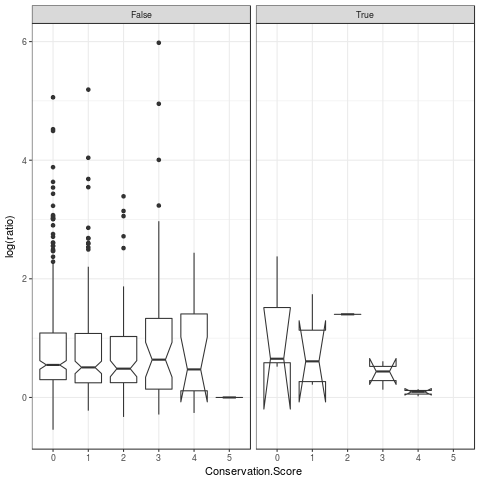

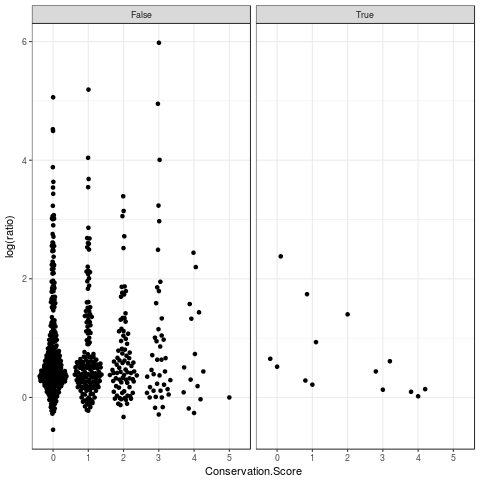

In [62]:
%%R
p = ggplot(conservation_df, aes(Conservation.Score, log(ratio))) +
geom_boxplot(notch=TRUE) +
facet_wrap(~in_idr) +
theme_bw()

print(p)

p = ggplot(conservation_df, aes(Conservation.Score, log(ratio))) +
geom_quasirandom() +
facet_wrap(~in_idr) +
theme_bw()

print(p)




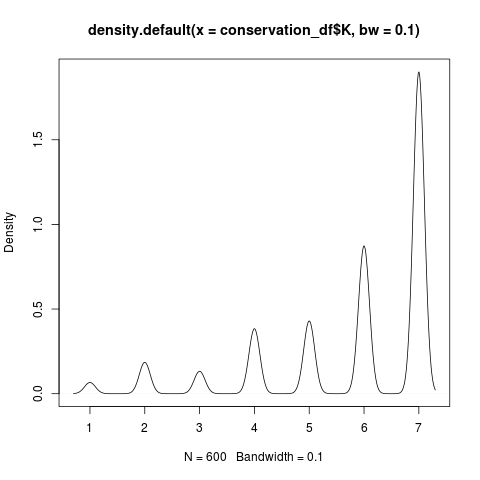

In [63]:
%%R
plot(density(conservation_df$K, bw=0.1))

In [64]:
%%R
print(head(conservation_df[order(-conservation_df$ratio),]))

    Accession. Site                      Alignment Conservation.Score
160     Q9DB20   97 KTTAAAAAAA---A-AAA--AAALAATTTA                  3
23      Q8BWT1  214 KKKKKKK-KNKKK-IKKKKKKKKKTKKKKK                  1
555     P08249  239 KKKKKKK-KKK-QKKKKKKKKKKKKKKKKK                  0
298     P42125  283 KKK-RRRRRK--KKKKKKKMH-MKRMMMMI                  3
366     P26443  480 KKKKKK-KK-KKKKKKKK-KKKKKKKKKKK                  0
432     Q8BMS1  644 KKK-KKKKKKKKKKKKKK-KKKKKKKKKKK                  0
    Danio.rerio Xenopus.tropicalis Gallus.gallus Bos.taurus Rattus.norvegicus
160           A                  A             A          A                 T
23            K                  T             K          K                 K
555           K                  K             K          K                 K
298           I                  R             M          K                 K
366           K                  K             K          K                 K
432           K                  K        

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


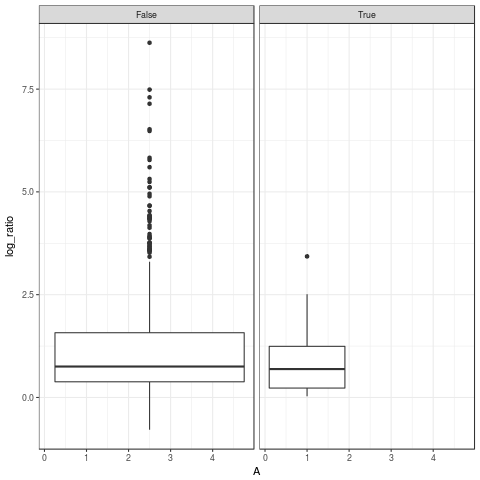

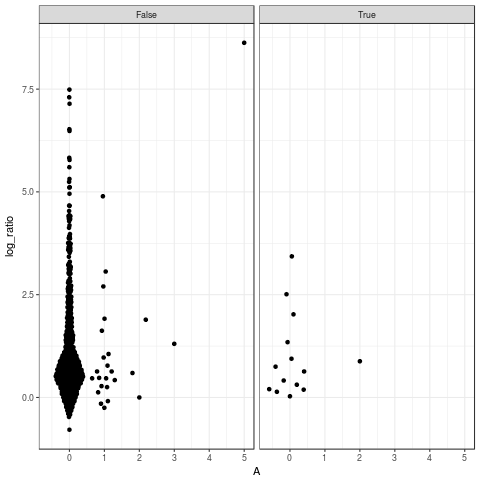

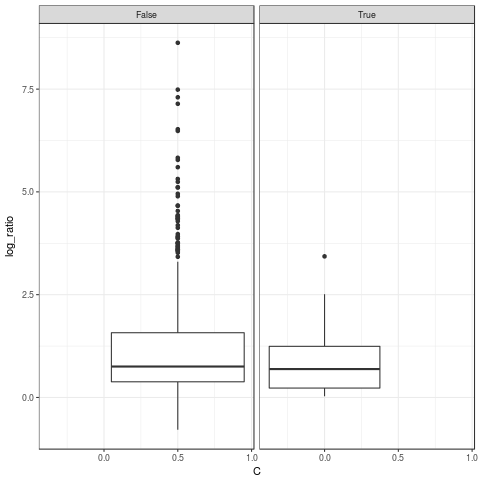

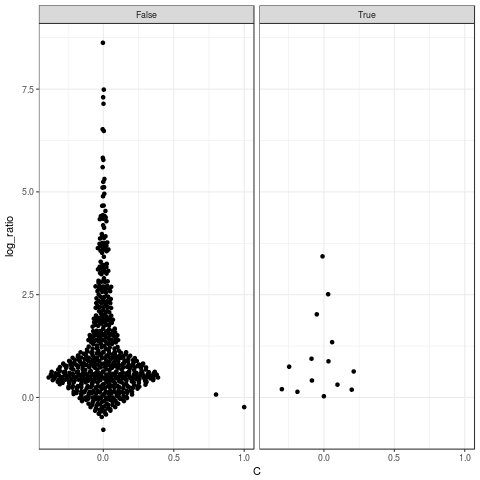

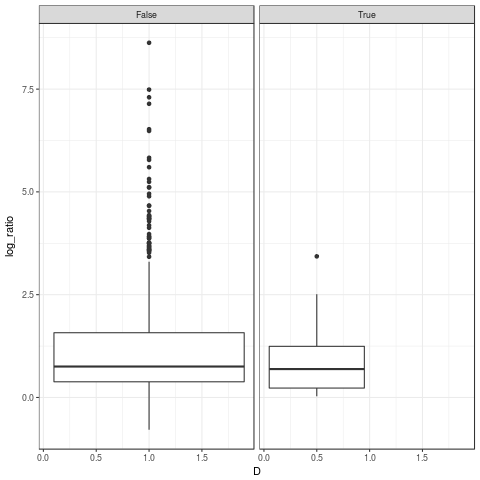

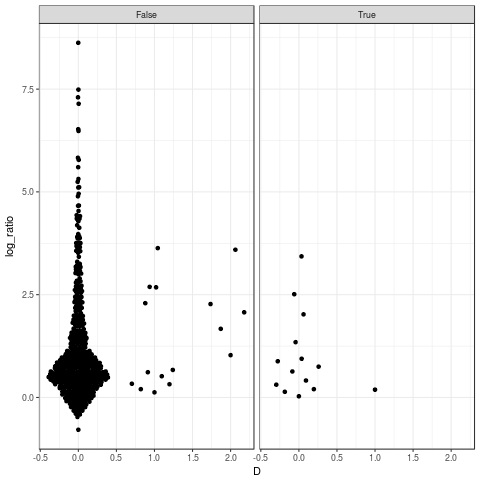

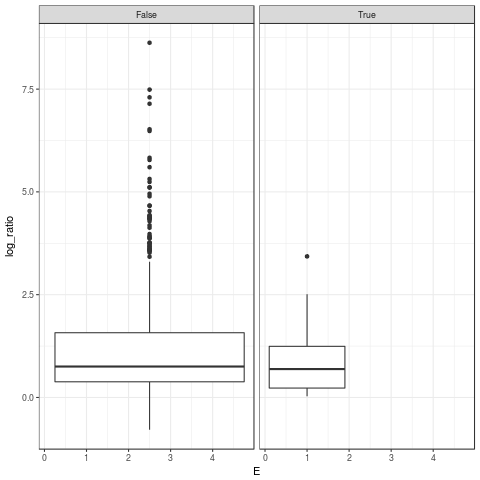

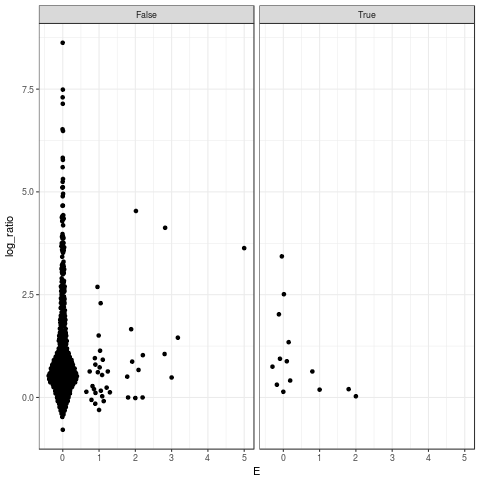

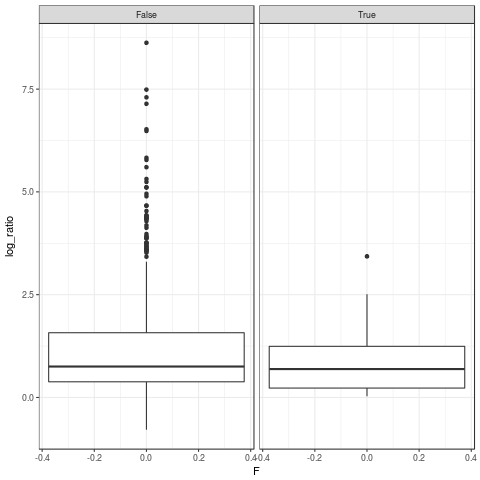

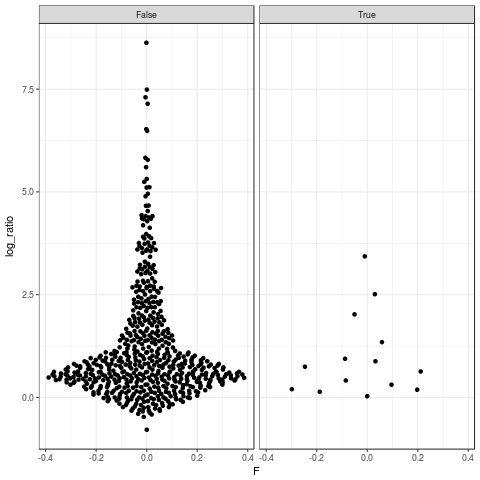

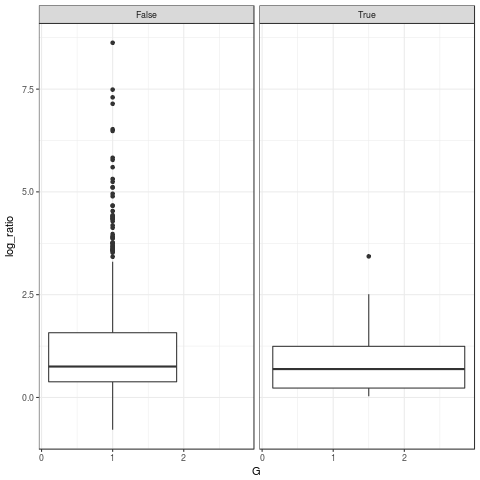

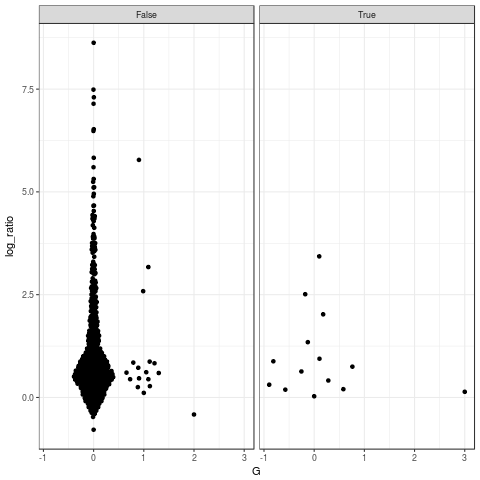

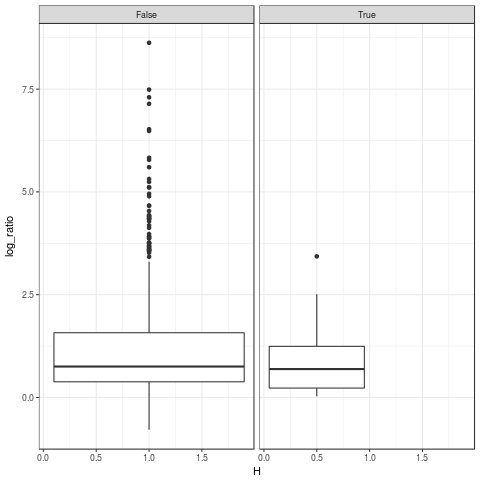

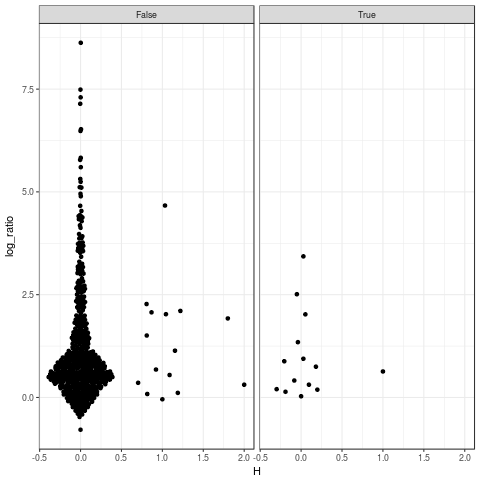

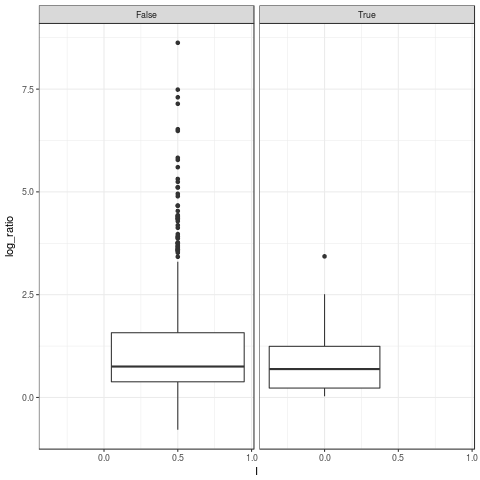

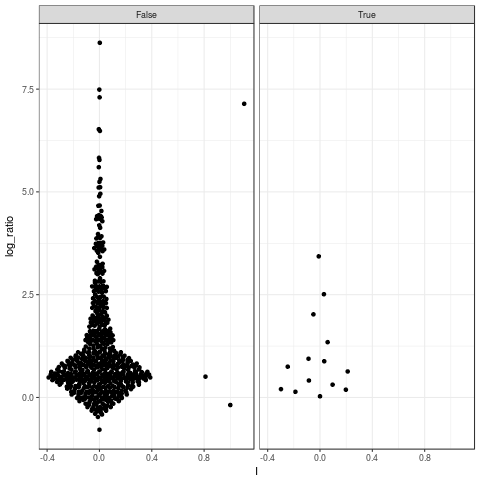

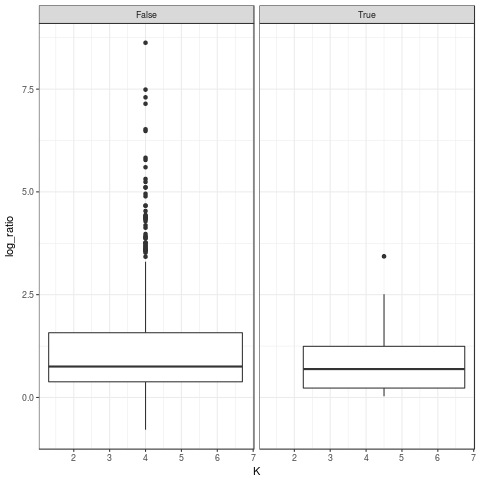

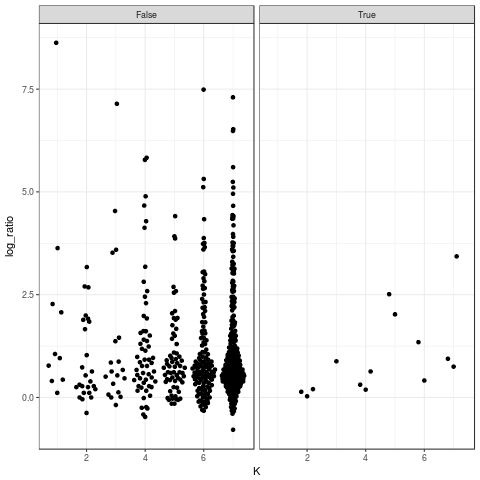

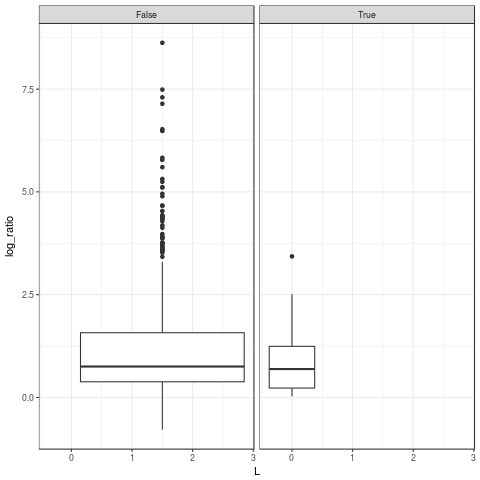

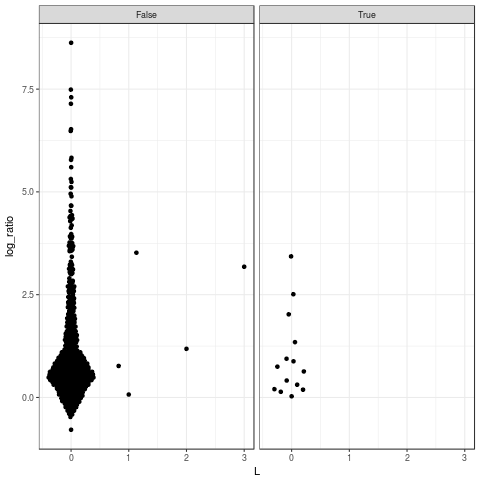

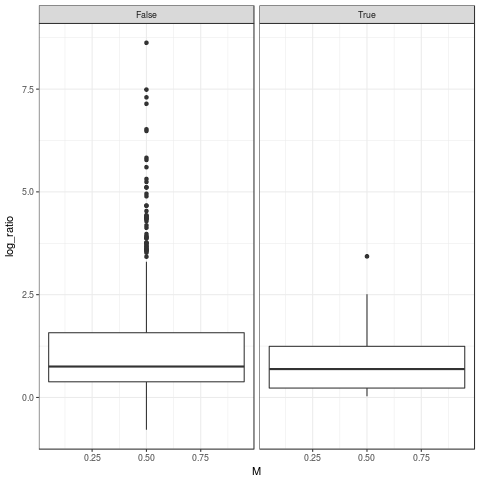

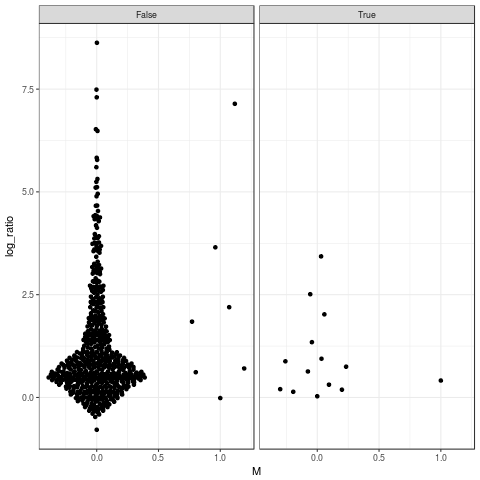

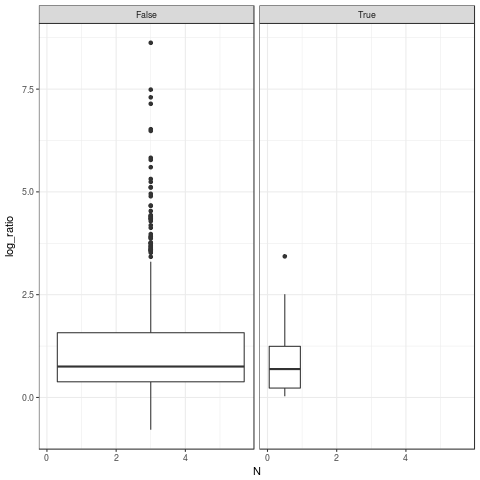

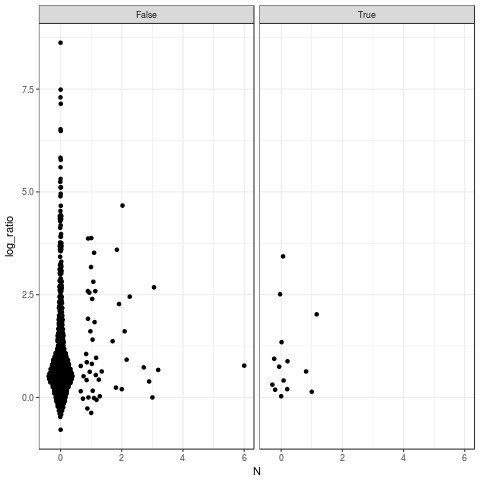

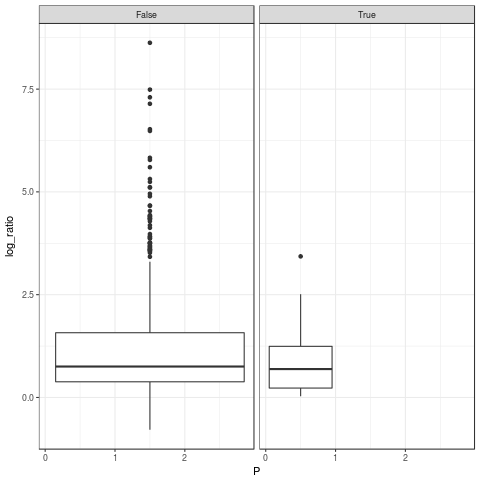

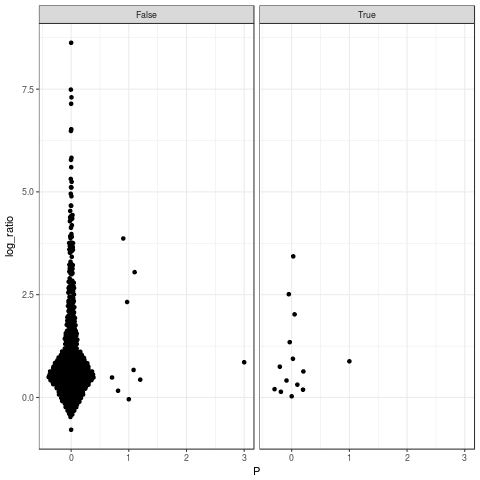

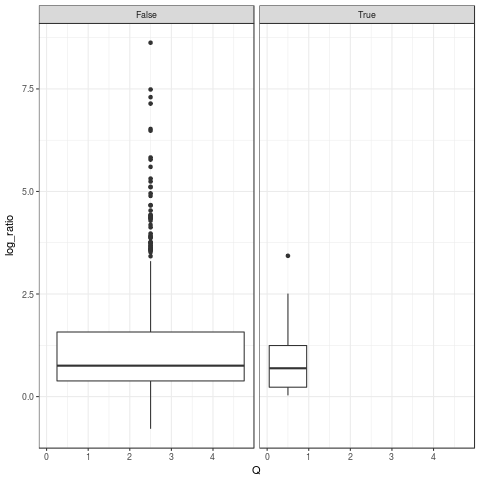

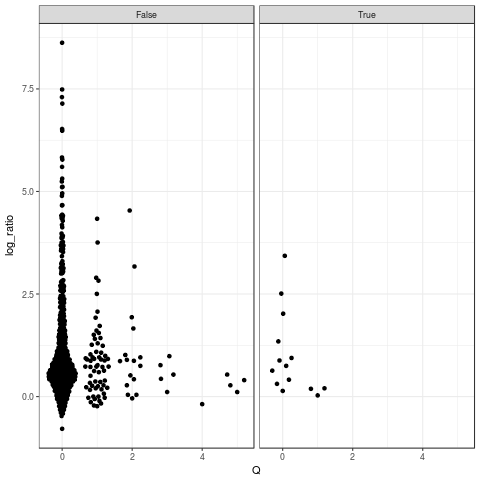

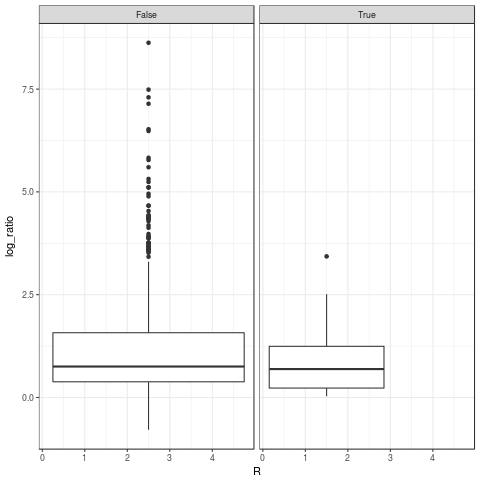

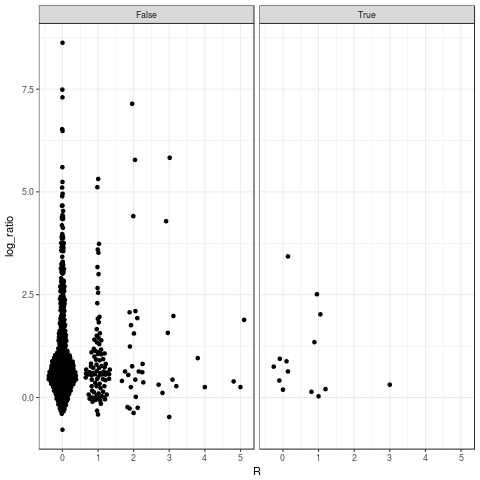

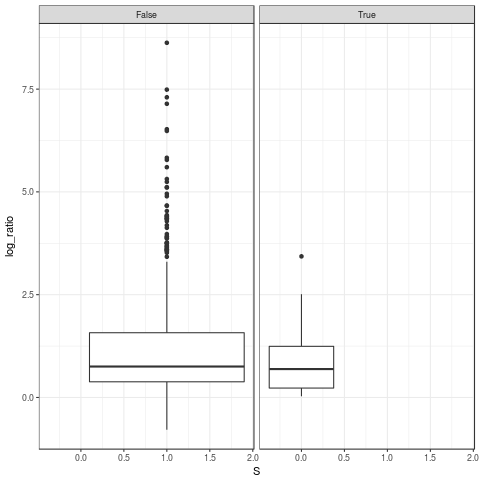

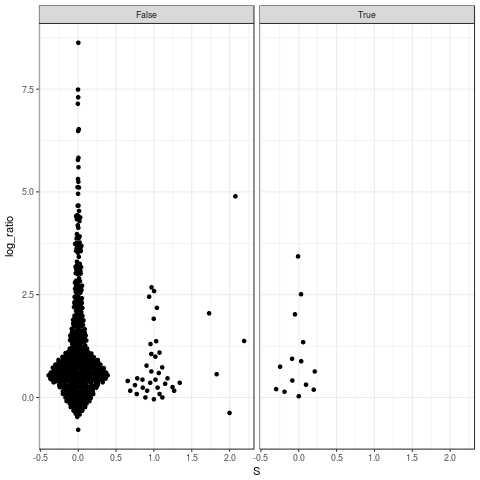

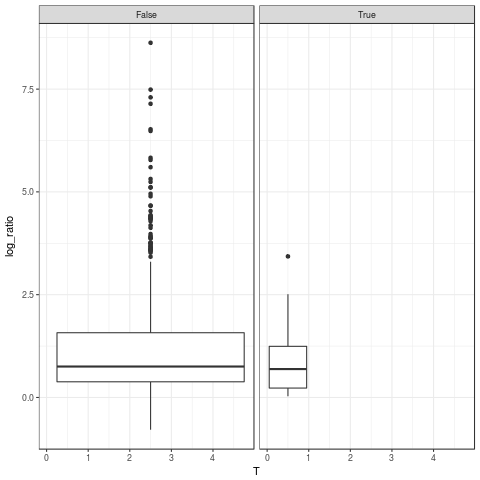

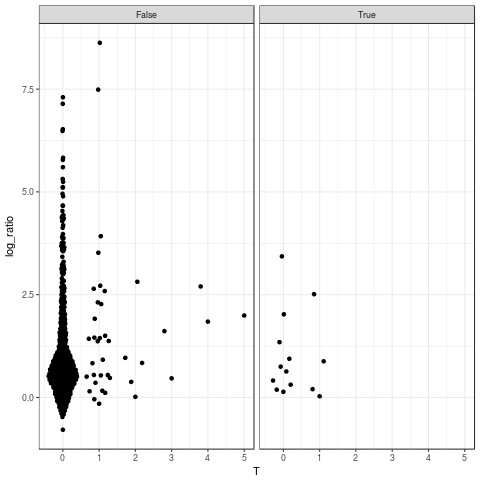

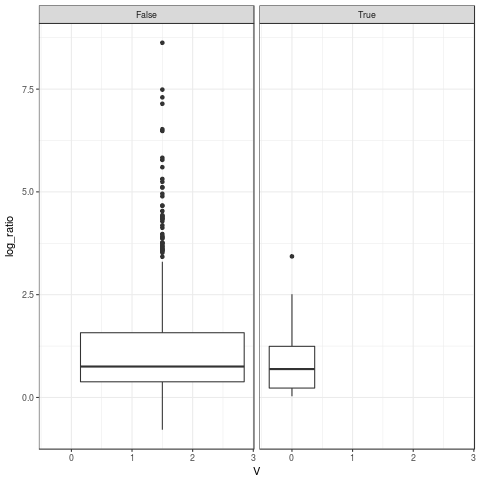

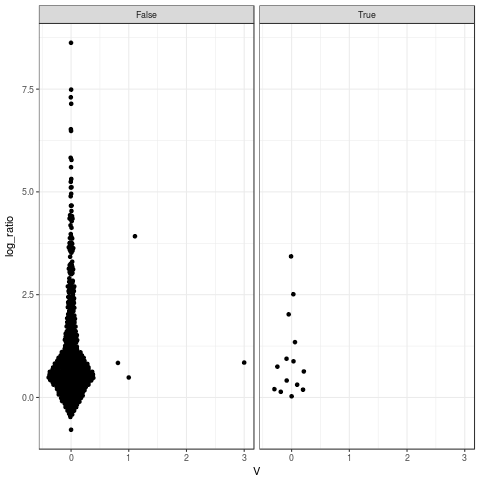

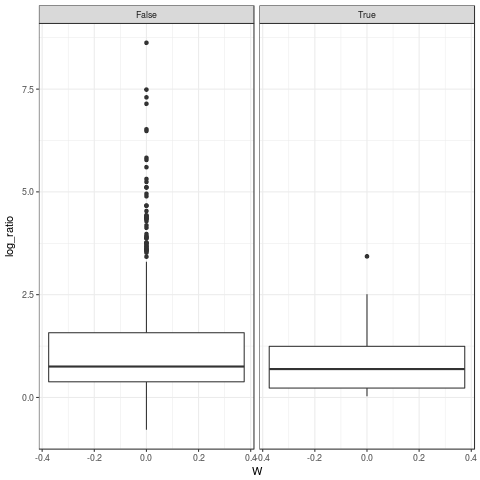

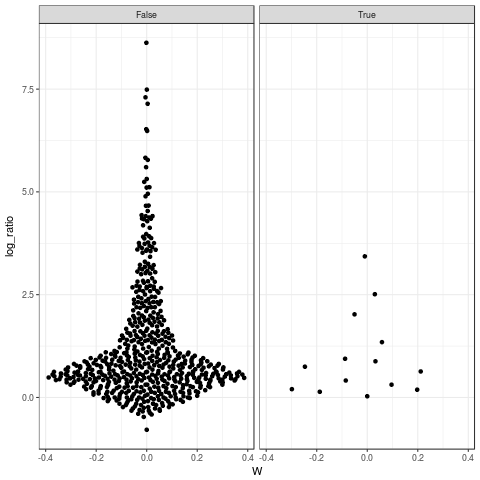

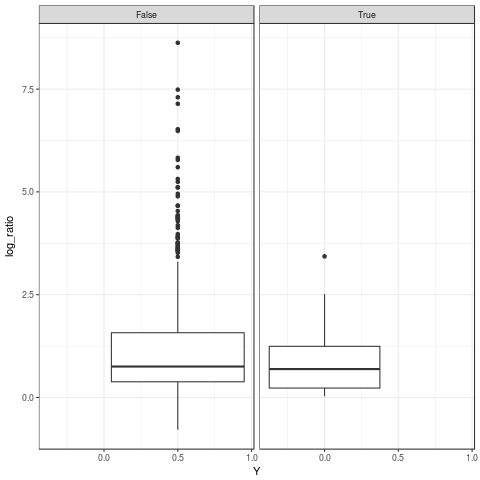

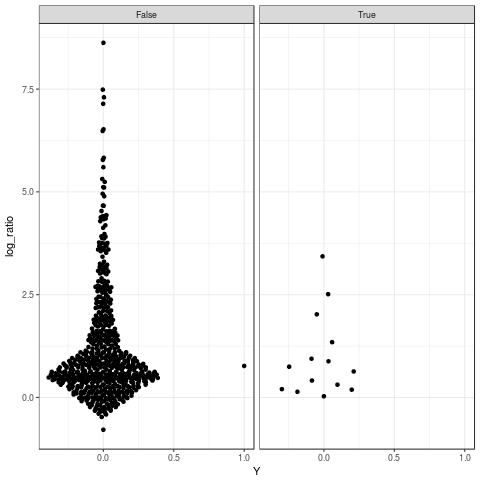

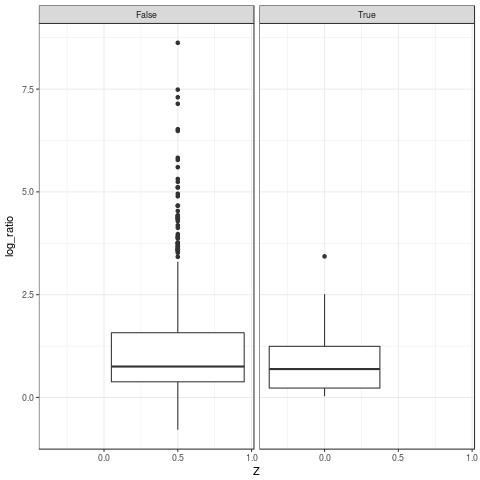

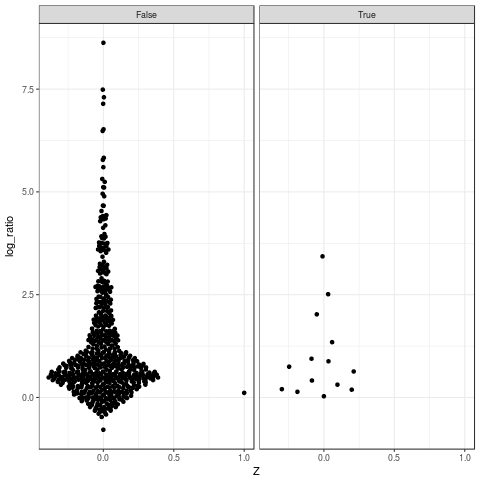

In [65]:
%%R
conservation_df$log_ratio <- log2(conservation_df$ratio)
for (aa in LETTERS) {
    if (!aa %in% c("B", "J", "O", "U", "X")){

        p = ggplot(conservation_df, aes_string(aa, "log_ratio")) +
        geom_boxplot() +
        facet_wrap(~in_idr) +
        theme_bw()

        print(p)
        ggsave(paste0("results/conservation/ratio_vs_", aa, "_boxplot.png"))
        
        p = ggplot(conservation_df, aes_string(aa, "log_ratio")) +
        geom_quasirandom() +
        facet_wrap(~in_idr) +
        theme_bw()

        print(p)
        ggsave(paste0("results/conservation/ratio_vs_", aa, "_quasirandom.png"))
    }
}



    Accession. Site                      Alignment Conservation.Score
699     Q9CZ13  248 KDKKKKKKKK-K-KKKKK-KKQQQRSQTSS                  3
94      Q8CHT0  357 KQS-HHHHQQR--QQRR---DDR-DDDDDD                  4
177     Q80XN0  258 KK-RKKKKRKRENDNNNK-KNQDDDAETNN                  3
286     Q9DBT9  469 KKESQQQQRKK--KKKEKSTNDDEEEE-QD                  3
307     Q9DBM2  288 KKKKKKKKKTKK-KKKKKK-KKKGDDNDDD                  2
487     Q61694  203 KN--NNNNN----Y-HH---I-DDDARKAT                  4
    Danio.rerio Xenopus.tropicalis Gallus.gallus Bos.taurus Rattus.norvegicus
699           S                  R             Q          K                 D
94            D                  D             R          R                 Q
177           N                  D             D          N                 K
286           D                  E             D          E                 K
307           D                  D             K          K                 K
487           T                  D        

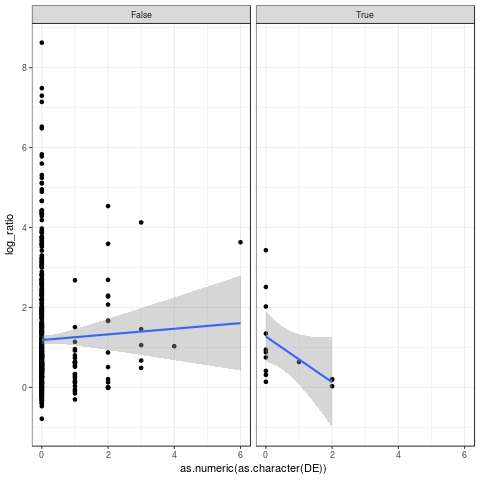

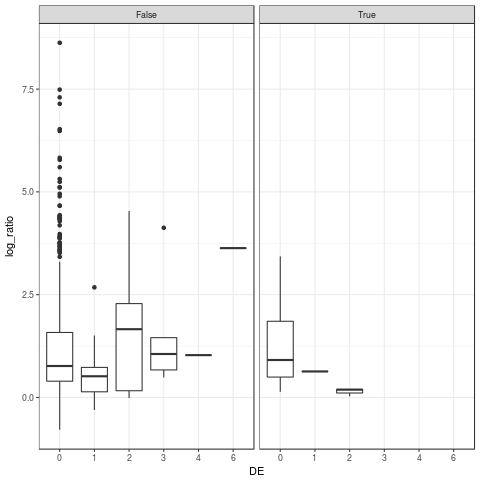

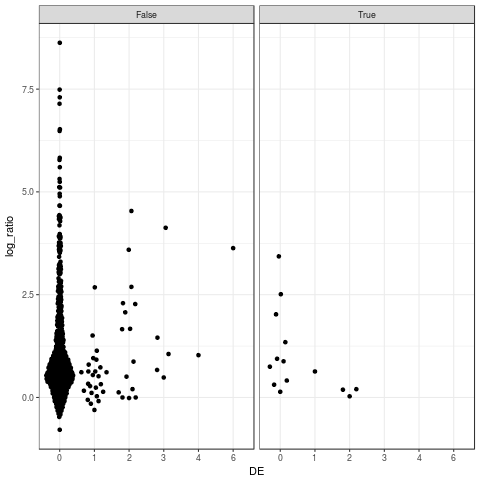

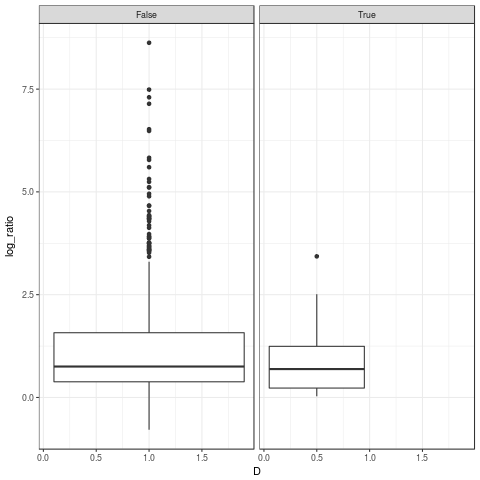

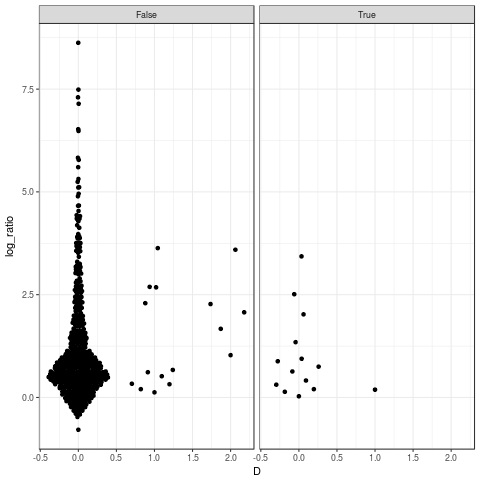

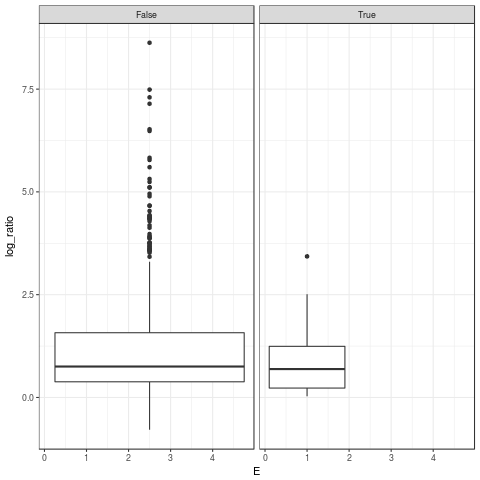

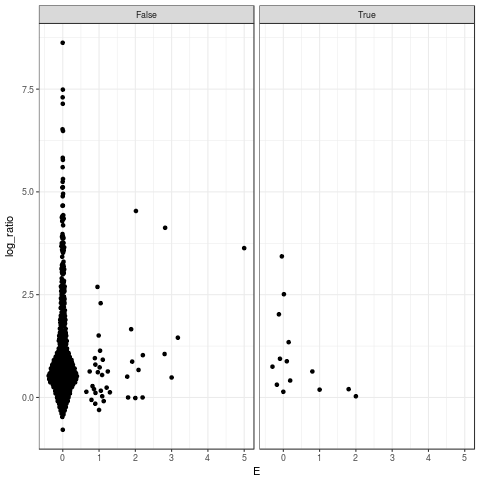

In [66]:
%%R

conservation_df["DE"] <- factor(as.numeric(as.character(conservation_df[['D']])) +
                          as.numeric(as.character(conservation_df[['E']])))


print(tail(conservation_df[order(conservation_df[['D']]),]))

p = ggplot(conservation_df, aes(as.numeric(as.character(DE)), log_ratio)) +
geom_point() +
geom_smooth(method="lm") +
facet_wrap(~in_idr) +
theme_bw()

print(p)

p = ggplot(conservation_df, aes_string("DE", "log_ratio")) +
geom_boxplot() +
facet_wrap(~in_idr) +
theme_bw()

print(p)

p = ggplot(conservation_df, aes_string("DE", "log_ratio")) +
geom_quasirandom() +
facet_wrap(~in_idr) +
theme_bw()

print(p)

p = ggplot(conservation_df, aes_string("D", "log_ratio")) +
geom_boxplot() +
facet_wrap(~in_idr) +
theme_bw()

print(p)

p = ggplot(conservation_df, aes_string("D", "log_ratio")) +
geom_quasirandom() +
facet_wrap(~in_idr) +
theme_bw()

print(p)

p = ggplot(conservation_df, aes_string("E", "log_ratio")) +
geom_boxplot() +
facet_wrap(~in_idr) +
theme_bw()

print(p)

p = ggplot(conservation_df, aes_string("E", "log_ratio")) +
geom_quasirandom() +
facet_wrap(~in_idr) +
theme_bw()

print(p)

In [67]:
%%R
print(dim(conservation_df))
tmp_df <- conservation_df[conservation_df$in_idr=='False',]
print(dim(tmp_df))
print(head(tmp_df))

for (k_level in unique(conservation_df$Ks)){
    if (k_level != 6){
        print(k_level)
        ratios_level = conservation_df[conservation_df$Ks==k_level, "ratio"]
        ratios_6 = conservation_df[conservation_df$Ks==6, "ratio"]
        print(median(ratios_level))
        print(median(ratios_6))
        }
        
}


[1] 600  42
[1] 586  42
  Accession. Site                      Alignment Conservation.Score Danio.rerio
1     Q9WVM8   69 KQKKKKKKKKK-KK-KKK-KKKKKK----R                  1           R
2     Q9WVM8  263 KKK-KKKKKKKKKKKKKKKK-KKKK-KKKK                  0           K
3     Q99K67   52 KKNNNNNNN-N-NN-QNN-NNNQNSTANNN                  4           N
4     Q99K67  286 KK--KKKKKKKKKKKKK---KKKKKNNNNN                  1           N
7     P61922  452 KKKKKKKKKKK-KKKKK-K-KKKKKSSSSR                  1           R
8     Q61102  216 KKKKKKKKK-KKKKKKK-KKKKKKKKKKKK                  0           K
  Xenopus.tropicalis Gallus.gallus Bos.taurus Rattus.norvegicus Homo.sapiens
1                  K             K          K                 Q            K
2                  K             K          K                 K            K
3                  S             Q          N                 K            N
4                  K             K          K                 K            K
7                  K           

In [68]:
ratio_ids = set(tmp_df['uniprot_id'])
conservation_ids = set(conservation_df['Accession#'])
print(len(ratio_ids))
print(len(conservation_ids))
print(len(ratio_ids.intersection(conservation_ids)))
print(list(ratio_ids.intersection(conservation_ids))[0:10])

204
157
136
['Q9JII6', 'Q80XN0', 'Q9WVD5', 'Q9CQ62', 'Q91X34', 'Q99JB2', 'Q99JY0', 'P26443', 'Q8QZT1', 'Q8BH95']


In [69]:
ensembl2Uniprot = {}
with IOTools.openFile("../raw/MOUSE_10090_idmapping_selected.tab.gz", "r") as inf:
    for line in inf:
        line = line.strip().split("\t")
        try:
            proteins = line[20].split("; ")
            for protein in proteins:
                if len(protein) > 0:
                    ensembl2Uniprot[protein] = line[0]
        except:
            pass
        
print(line)
print(line[0])
print(line[20])

['A0A0A6YXR5', 'A0A0A6YXR5_MOUSE', '', '', '', '', 'GO:0006511', 'UniRef100_A0A0A6YW29', 'UniRef90_A0A0A6YW29', 'UniRef50_A0A0A6YW29', 'UPI00053BD71E', '', '10090', '', '', '19468303', 'CT571271', '-', 'ENSMUSG00000064145', 'ENSMUST00000193552', 'ENSMUSP00000142102', '10422847; 10431818; 11217851; 12466851; 12520002; 12904583; 14610273; 16118314; 16141072; 18799693; 22819825; 23179078; 24486325']
A0A0A6YXR5
ENSMUSP00000142102


In [70]:
print(list(ensembl2Uniprot.keys())[0:10])
print(ensembl2Uniprot['ENSMUSP00000088288'])

['ENSMUSP00000143624', 'ENSMUSP00000117993', 'ENSMUSP00000124886', 'ENSMUSP00000095589', 'ENSMUSP00000148563', 'ENSMUSP00000136265', 'ENSMUSP00000124344', 'ENSMUSP00000028205', 'ENSMUSP00000026555', 'ENSMUSP00000099438']
Q64523


In [77]:
abundance_df = pd.read_table("../raw/10090-WHOLE_ORGANISM-integrated.txt",
                             sep="\t",comment='#', header=None, usecols=[1,2])
abundance_df.columns = ["id", "NULL"]
abundance_df['id'] = [x.split(".")[1] for x in abundance_df['id']]
abundance_df['uniprot_id'] = [ensembl2Uniprot[x] if x in ensembl2Uniprot else "" for x in abundance_df['id']]

protein_lengths = {}

n = 0
for accession, tax_id, seq, method in sequence.getSequences(abundance_df['uniprot_id']):
    n+=1
    if n % 100 ==0:
        print(n)
    try:
        protein_lengths[accession] = len(seq)
    except:
        pass   

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100


IndexError: list index out of range

In [78]:
def parseAbundance(infile, abundance_column_name='abundance'):
    abundance_df = pd.read_table(infile, sep="\t",comment='#', header=None, usecols=[1,2])

    abundance_df.columns = ["id", abundance_column_name]
    abundance_df['id'] = [x.split(".")[1] for x in abundance_df['id']]
    abundance_df['uniprot_id'] = [ensembl2Uniprot[x] if x in ensembl2Uniprot else "" for x in abundance_df['id']]
    abundance_df = abundance_df[[len(x) > 0 for x in abundance_df['uniprot_id']]]
    abundance_df = pd.DataFrame(
        abundance_df.groupby(["uniprot_id"])[abundance_column_name].agg(np.mean)).reset_index()
    abundance_df['length'] = [protein_lengths[x] if x in protein_lengths else None
                          for x in abundance_df['uniprot_id']]
    return abundance_df

liver_abundance_df = parseAbundance("../raw/10090-Liver_geiger_2013.txt", "liver_abundance")
full_abundance_df = parseAbundance("../raw/10090-WHOLE_ORGANISM-integrated.txt", "integrated_abundance")

In [79]:
%%R
library(reshape2)
#[ratio_plus_abundance_df['modification']=='succinylation',]

casted_df <- dcast(data = ratio_idr_df[ratio_idr_df$modification=='succinylation',],
                   Final.Localization.Assignment+uniprot_id~reference,
                   fun.aggregate = length, value.var = "modification")
print(head(casted_df))

print(head(ratio_idr_df))

tmp_df = ratio_idr_df[ratio_idr_df$modification=='succinylation',]
print(dim(tmp_df))
tmp_df = tmp_df[tmp_df$ratio!=-1,]
print(dim(tmp_df))
tmp_df = tmp_df[is.finite(tmp_df$ratio),]
print(dim(tmp_df))
tmp_df$ratio = as.numeric(as.character(tmp_df$ratio))
print(head(tmp_df))

casted_df2 <- dcast(data = tmp_df,
                   Final.Localization.Assignment+uniprot_id~reference,
                   fun.aggregate = median, value.var = "ratio")
print(head(casted_df2))



  Final.Localization.Assignment uniprot_id Park_et_al_2013 Rardin_et_al_2013
1                  40S Ribosome     P14131               0                 0
2                  40S Ribosome     P14206               0                 0
3                  40S Ribosome     P29341               1                 0
4                  40S Ribosome     P60867               2                 0
5                  40S Ribosome     P62082               0                 0
6                  40S Ribosome     P62242               2                 0
  Sadhukhan_et_al_2016 Weinert_et_al_2013
1                    0                  2
2                    0                  2
3                    0                  0
4                    0                  0
5                    0                  2
6                    0                  1
  uniprot_id position modification          reference            ratio p_value
1     A0JNU3      354 malonylation  Colaka_et_al_2015               -1      -1
2     A2A

In [80]:
%%R -i full_abundance_df -i liver_abundance_df

print(dim(full_abundance_df))
print(dim(ratio_idr_df))

ratio_plus_abundance_df <- merge(full_abundance_df, casted_df, by='uniprot_id', all.x=T)
print(dim(ratio_plus_abundance_df))

print(dim(liver_abundance_df))

ratio_plus_abundance_df <- merge(liver_abundance_df, ratio_plus_abundance_df, by='uniprot_id', all.y=T)
print(dim(ratio_plus_abundance_df))

print(head(ratio_plus_abundance_df))

print(ratio_plus_abundance_df[ratio_plus_abundance_df$uniprot_id=='A0A023T778',])

ratio_plus_abundance_df2 <- merge(full_abundance_df, casted_df2, by='uniprot_id', all.x=T)
ratio_plus_abundance_df2 <- merge(liver_abundance_df, ratio_plus_abundance_df2, by='uniprot_id', all.y=T)

[1] 19023     3
[1] 12888     8
[1] 19023     8
[1] 7341    3
[1] 19023    10
  uniprot_id liver_abundance length.x integrated_abundance length.y
1 A0A023T778          17.800      148               34.000      148
2 A0A0A0MQ68         627.000      447              101.000      447
3 A0A0A0MQ76          47.100      NaN               84.400      NaN
4 A0A0A0MQ89           0.866      NaN                0.619      NaN
5 A0A0A0MQ90          64.700      NaN              124.000      NaN
6 A0A0A0MQ94          16.500       72               10.300       72
  Final.Localization.Assignment Park_et_al_2013 Rardin_et_al_2013
1                          <NA>              NA                NA
2                          <NA>              NA                NA
3                          <NA>              NA                NA
4                          <NA>              NA                NA
5                          <NA>              NA                NA
6                          <NA>              NA   

In [81]:
%%R
print(head(ratio_plus_abundance_df2[ratio_plus_abundance_df2['uniprot_id']=='Q9Z2Y8',]))

     uniprot_id liver_abundance length.x integrated_abundance length.y
7314     Q9Z2Y8             256      274                 46.6      274
     Final.Localization.Assignment Park_et_al_2013 Rardin_et_al_2013
7314                  unclassified        1.549569                NA
     Sadhukhan_et_al_2016
7314                   NA


In [82]:
%%R
final_df = melt(ratio_plus_abundance_df,
                id=c("uniprot_id", "integrated_abundance", "liver_abundance",
                     "length.x", "length.y", "Final.Localization.Assignment"))

final_df2 = melt(ratio_plus_abundance_df2,
                id=c("uniprot_id", "integrated_abundance", "liver_abundance",
                     "length.x", "length.y", "Final.Localization.Assignment"))



final_df$Final.Localization.Assignment = gsub(
    "Endoplasmic reticulum/Golgi apparatus", "ER / Golgi", final_df$Final.Localization.Assignment)
final_df2$Final.Localization.Assignment = gsub(
    "Endoplasmic reticulum/Golgi apparatus", "ER / Golgi", final_df2$Final.Localization.Assignment)



final_df$label <- sapply(strsplit(as.character(final_df$variable), "_", fixed=T),'[',1)
final_df2$label <- sapply(strsplit(as.character(final_df2$variable), "_", fixed=T),'[',1)

print(head(final_df))
print(head(final_df2))

  uniprot_id integrated_abundance liver_abundance length.x length.y
1 A0A023T778               34.000          17.800      148      148
2 A0A0A0MQ68              101.000         627.000      447      447
3 A0A0A0MQ76               84.400          47.100      NaN      NaN
4 A0A0A0MQ89                0.619           0.866      NaN      NaN
5 A0A0A0MQ90              124.000          64.700      NaN      NaN
6 A0A0A0MQ94               10.300          16.500       72       72
  Final.Localization.Assignment        variable value label
1                          <NA> Park_et_al_2013    NA  Park
2                          <NA> Park_et_al_2013    NA  Park
3                          <NA> Park_et_al_2013    NA  Park
4                          <NA> Park_et_al_2013    NA  Park
5                          <NA> Park_et_al_2013    NA  Park
6                          <NA> Park_et_al_2013    NA  Park
  uniprot_id integrated_abundance liver_abundance length.x length.y
1 A0A023T778               34.000   

[1] 21813    12
  uniprot_id liver_abundance length.x integrated_abundance length.y position
1 A0A023T778          17.800      148               34.000      148     <NA>
2 A0A0A0MQ68         627.000      447              101.000      447     <NA>
3 A0A0A0MQ76          47.100      NaN               84.400      NaN     <NA>
4 A0A0A0MQ89           0.866      NaN                0.619      NaN     <NA>
5 A0A0A0MQ90          64.700      NaN              124.000      NaN     <NA>
6 A0A0A0MQ94          16.500       72               10.300       72     <NA>
  modification reference ratio p_value in_idr Final.Localization.Assignment
1         <NA>      <NA>  <NA>    <NA>     NA                          <NA>
2         <NA>      <NA>  <NA>    <NA>     NA                          <NA>
3         <NA>      <NA>  <NA>    <NA>     NA                          <NA>
4         <NA>      <NA>  <NA>    <NA>     NA                          <NA>
5         <NA>      <NA>  <NA>    <NA>     NA                    

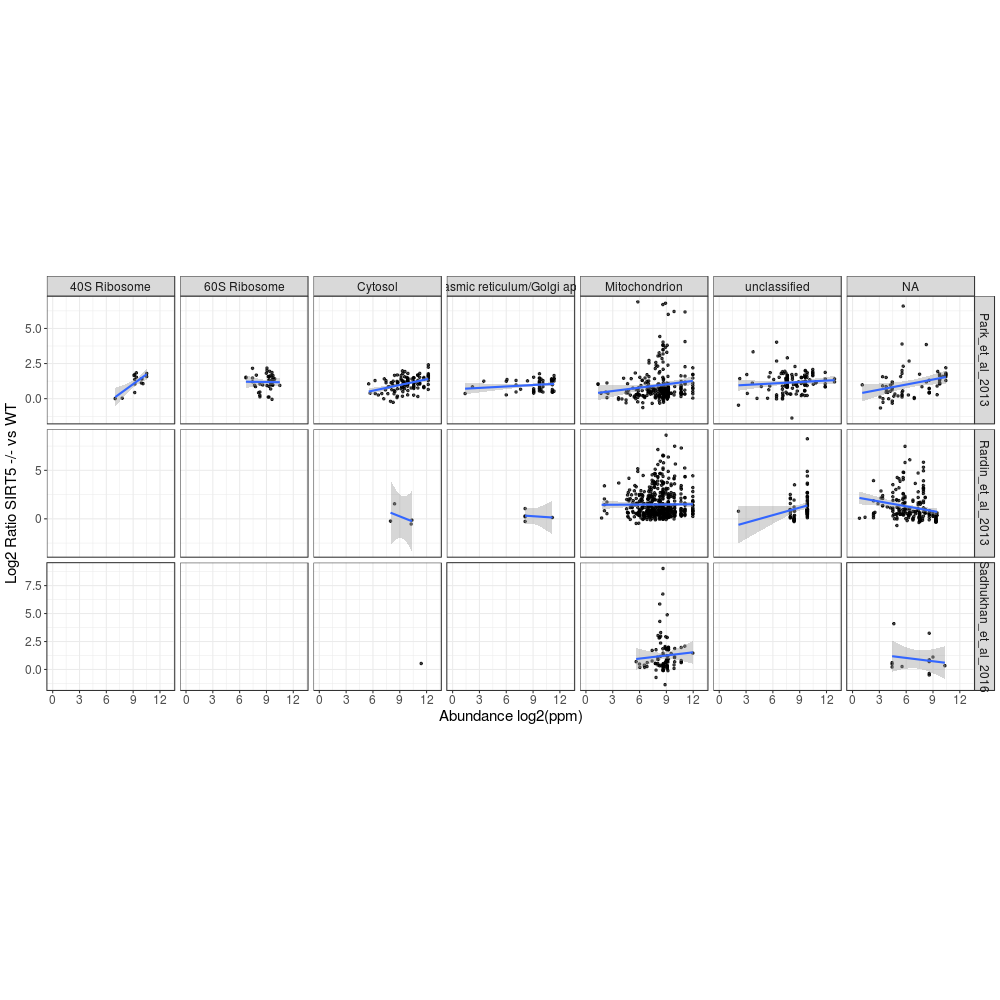

In [83]:
%%R -h 1000 -w 1000

library(ggplot2)

m_txt <- element_text(size=15)

my_theme <- theme(
    aspect.ratio=1,
    text=m_txt)

exclude_organelles = c("Endosome", "Lysosome", "Peroxisome",
                       "Extracellular matrix", "Proteasome",
                       "Nucleus - Chromatin", "Nucleus - Non-chromatin",
                       "Plasma membrane", "Actin cytoskeleton")
tmp_df <- ratio_idr_df[ratio_idr_df$modification=='succinylation',]
tmp_df <- merge(full_abundance_df, tmp_df, by='uniprot_id', all.x=T)
tmp_df <- merge(liver_abundance_df, tmp_df, by='uniprot_id', all.y=T)

print(dim(tmp_df))
print(head(tmp_df))

tmp_df = tmp_df[tmp_df$ratio!=-1,]
tmp_df = tmp_df[is.finite(tmp_df$ratio),]

tmp_df <- tmp_df[!tmp_df[['Final.Localization.Assignment']] %in% exclude_organelles,]
tmp_df$ratio = as.numeric(as.character(tmp_df$ratio))

p <- ggplot(tmp_df, aes(log(integrated_abundance, 2), log(ratio,2))) +
geom_point(size=1, alpha=0.75) +
geom_smooth(method='lm') +
facet_grid(reference~Final.Localization.Assignment, scales='free_y') +
theme_bw() +
scale_x_continuous(limits=c(0,13), breaks=seq(0,12,3)) +
xlab("Abundance log2(ppm)") + ylab("Log2 Ratio SIRT5 -/- vs WT") +
my_theme

print(p)

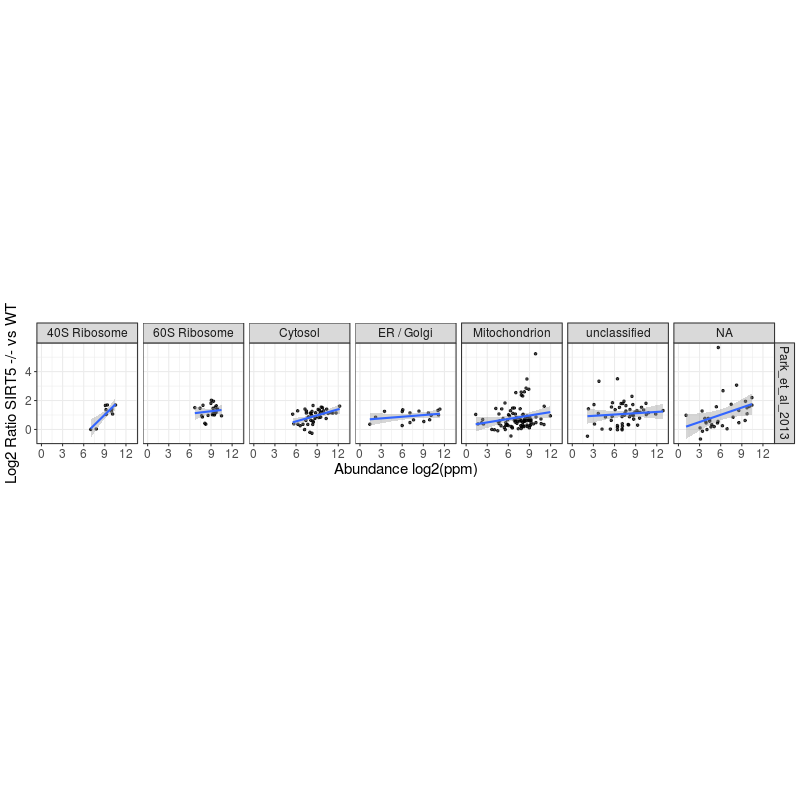

In [84]:
%%R -w 800 -h 800
library(ggplot2)

m_txt <- element_text(size=15)

my_theme <- theme(
    aspect.ratio=1,
    text=m_txt)


tmp_df <- final_df2

tmp_df <- final_df2[final_df2$variable %in% c("Park_et_al_2013"),]
exclude_organelles = c("Endosome", "Lysosome", "Peroxisome",
                       "Extracellular matrix", "Proteasome",
                       "Nucleus - Chromatin", "Nucleus - Non-chromatin",
                       "Plasma membrane", "Actin cytoskeleton")
tmp_df <- tmp_df[!tmp_df[['Final.Localization.Assignment']] %in% exclude_organelles,]
#tmp_df <- tmp_df[tmp_df['value']<40,]


p <- ggplot(tmp_df, aes(log(integrated_abundance, 2), log(value,2))) +
geom_point(size=1, alpha=0.75) +
geom_smooth(method='lm') +
facet_grid(variable~Final.Localization.Assignment, scales='free_y') +
theme_bw() +
scale_x_continuous(limits=c(0,13), breaks=seq(0,12,3)) +
xlab("Abundance log2(ppm)") + ylab("Log2 Ratio SIRT5 -/- vs WT") +
my_theme

print(p)

ggsave("./results/integrated_abundance_ratio.png", width = 12, height=5)

    uniprot_id integrated_abundance liver_abundance length.x length.y
290     A2AKK5                 5.20            14.8      416      416
322     A2AS89               116.00           137.0      358      358
324     A2ATU0                26.70           175.0      921      921
361     A6H5Y3                 0.36            12.4     1253     1253
387     B1AR13                12.80            61.2      137      137
407     B1AXP6                14.00            11.4       51       51
    Final.Localization.Assignment        variable value label
290                          <NA> Park_et_al_2013     0  Park
322                          <NA> Park_et_al_2013     0  Park
324                 Mitochondrion Park_et_al_2013     0  Park
361                          <NA> Park_et_al_2013     0  Park
387                 Mitochondrion Park_et_al_2013     2  Park
407                 Mitochondrion Park_et_al_2013     0  Park


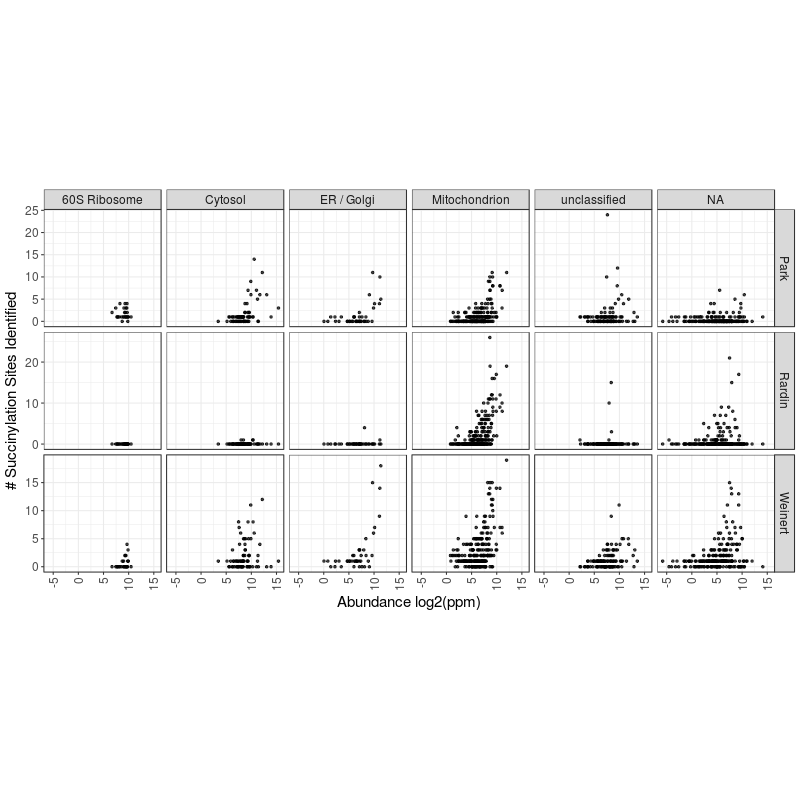

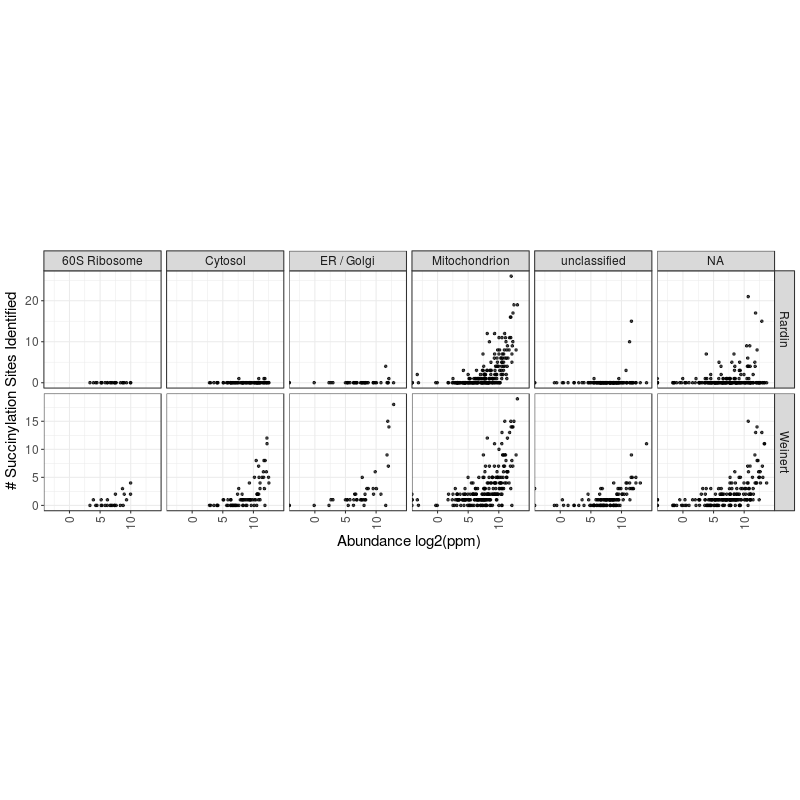

In [98]:
%%R -w 800 -h 800
library(ggplot2)

m_txt <- element_text(size=15)

my_theme <- theme(
    aspect.ratio=1,
    text=m_txt,
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))


tmp_df <- final_df[final_df$variable %in% c("Park_et_al_2013", "Rardin_et_al_2013", "Weinert_et_al_2013"),]
tmp_df <- tmp_df[is.finite(tmp_df$value),]
tmp_df <- tmp_df[tmp_df$value<40,]
exclude_organelles = c("Endosome", "Lysosome", "Peroxisome",
                       "Extracellular matrix", "Proteasome",
                       "Nucleus - Chromatin", "Nucleus - Non-chromatin",
                       "Plasma membrane", "Actin cytoskeleton",
                       "40S Ribosome")
tmp_df <- tmp_df[!tmp_df[['Final.Localization.Assignment']] %in% exclude_organelles,]
print(head(tmp_df))


p <- ggplot(tmp_df, aes(log(integrated_abundance, 2), value)) +
geom_point(size=1, alpha=0.75) +
facet_grid(label~Final.Localization.Assignment, scales='free_y') +
theme_bw() +
xlab("Abundance log2(ppm)") + ylab("# Succinylation Sites Identified") +
my_theme

print(p)

ggsave("./results/integrated_abundance_number_succ.png", width = 12, height=5)


tmp_df2 <- tmp_df[tmp_df$variable %in% c("Weinert_et_al_2013", "Rardin_et_al_2013"),]

p <- ggplot(tmp_df2, aes(log(liver_abundance, 2), value)) +
geom_point(size=1, alpha=0.75) +
facet_grid(label~Final.Localization.Assignment, scales='free_y') +
theme_bw() + 
xlab("Abundance log2(ppm)") + ylab("# Succinylation Sites Identified") +
my_theme

print(p)

ggsave("./results/liver_abundance_number_succ.png", width = 15, height=4)


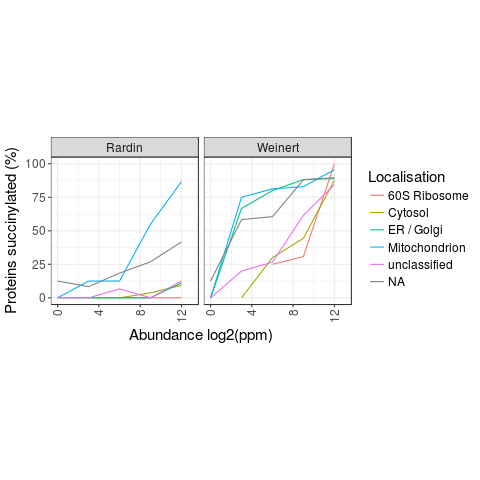

In [91]:
%%R
tmp_df2$binned_abundance = 3*.bincode(log(tmp_df2$liver_abundance, 2), seq(-3,12,3)) - 3
p <- ggplot(tmp_df2, aes(binned_abundance, value, colour=Final.Localization.Assignment)) +
stat_summary(fun.y = function(x) 100*mean(x>0), geom = "line") +
#stat_summary(fun.y = function(x) 100*mean(x>0), geom = "point") +
facet_grid(.~label, scales='free_y') +
theme_bw() +
ylim(0,100) +
scale_x_continuous(limits=c(0,13), breaks=seq(0,12,4)) +
xlab("Abundance log2(ppm)") + ylab("Proteins succinylated (%)") +
scale_colour_discrete(name="Localisation") +
my_theme

print(p)
    
ggsave("./results/liver_abundance_fraction_succ.png", width = 9, height=3)

In [99]:
%%R
print(head(tmp_df))
print(head(tmp_df2))

    uniprot_id integrated_abundance liver_abundance length.x length.y
290     A2AKK5                 5.20            14.8      416      416
322     A2AS89               116.00           137.0      358      358
324     A2ATU0                26.70           175.0      921      921
361     A6H5Y3                 0.36            12.4     1253     1253
387     B1AR13                12.80            61.2      137      137
407     B1AXP6                14.00            11.4       51       51
    Final.Localization.Assignment        variable value label
290                          <NA> Park_et_al_2013     0  Park
322                          <NA> Park_et_al_2013     0  Park
324                 Mitochondrion Park_et_al_2013     0  Park
361                          <NA> Park_et_al_2013     0  Park
387                 Mitochondrion Park_et_al_2013     2  Park
407                 Mitochondrion Park_et_al_2013     0  Park
      uniprot_id integrated_abundance liver_abundance length.x length.y
1931

In [95]:
%%R -w 800 -h 800
library(ggplot2)

tmp_df <- final_df[final_df$variable %in% c("Park_et_al_2013", "Rardin_et_al_2013"),]
print(head(tmp_df))
exclude_organelles = c("Endosome", "Lysosome", "Peroxisome",
                       "Extracellular matrix", "Proteasome")
tmp_df <- tmp_df[!tmp_df[['Final.Localization.Assignment']] %in% exclude_organelles,]
tmp_df <- tmp_df[tmp_df['succinylation']<40,]


p <- ggplot(tmp_df, aes(log(abundance, 2), succinylation)) +
geom_point(size=1, alpha=0.75) +
facet_grid(Final.Localization.Assignment~reference, scales='free') +
theme_bw()
print(p)

tmp_df <- casted_df[casted_df$reference %in% c("Weinert_et_al_2013"),]
exclude_organelles = c("Endosome", "Lysosome", "Peroxisome",
                       "Extracellular matrix", "Proteasome")
tmp_df <- tmp_df[!tmp_df[['Final.Localization.Assignment']] %in% exclude_organelles,]
tmp_df <- tmp_df[tmp_df['succinylation']<40,]

p <- ggplot(tmp_df, aes(log(abundance, 2), succinylation/length)) +
geom_point(size=1, alpha=0.75) +
facet_grid(Final.Localization.Assignment~reference, scales='free') +
theme_bw()
print(p)

p <- ggplot(tmp_df, aes(log(abundance, 2), succinylation)) +
geom_point(size=1, alpha=0.75) +
facet_grid(Final.Localization.Assignment~reference, scales='free') +
theme_bw()
print(p)



print(table(casted_df$Final.Localization.Assignment))

  uniprot_id integrated_abundance liver_abundance length.x length.y
1 A0A023T778               34.000          17.800      148      148
2 A0A0A0MQ68              101.000         627.000      447      447
3 A0A0A0MQ76               84.400          47.100      NaN      NaN
4 A0A0A0MQ89                0.619           0.866      NaN      NaN
5 A0A0A0MQ90              124.000          64.700      NaN      NaN
6 A0A0A0MQ94               10.300          16.500       72       72
  Final.Localization.Assignment        variable value label
1                          <NA> Park_et_al_2013    NA  Park
2                          <NA> Park_et_al_2013    NA  Park
3                          <NA> Park_et_al_2013    NA  Park
4                          <NA> Park_et_al_2013    NA  Park
5                          <NA> Park_et_al_2013    NA  Park
6                          <NA> Park_et_al_2013    NA  Park
Error in `[.data.frame`(tmp_df, "succinylation") : 
  undefined columns selected


In [96]:
%%R
print(head(casted_df))

  Final.Localization.Assignment uniprot_id Park_et_al_2013 Rardin_et_al_2013
1                  40S Ribosome     P14131               0                 0
2                  40S Ribosome     P14206               0                 0
3                  40S Ribosome     P29341               1                 0
4                  40S Ribosome     P60867               2                 0
5                  40S Ribosome     P62082               0                 0
6                  40S Ribosome     P62242               2                 0
  Sadhukhan_et_al_2016 Weinert_et_al_2013
1                    0                  2
2                    0                  2
3                    0                  0
4                    0                  0
5                    0                  2
6                    0                  1


In [94]:
%%R -h 1000 -w 1000

tmp_df <- casted_df[casted_df$reference %in% c("Park_et_al_2013", "Rardin_et_al_2013"),]
exclude_organelles = c("Endosome", "Lysosome", "Peroxisome",
                       "Extracellular matrix", "Proteasome")
tmp_df <- tmp_df[!tmp_df[['Final.Localization.Assignment']] %in% exclude_organelles,]
tmp_df <- tmp_df[tmp_df['succinylation']<40,]

p <- ggplot(tmp_df, aes(log(abundance, 2), log(as.numeric(as.character(ratio)),2))) +
geom_point(size=1, alpha=0.75) +
facet_grid(Final.Localization.Assignment~reference)+#scales='free_y') +
theme_bw()
print(p)

print(table(casted_df$Final.Localization.Assignment))


Error in `[.data.frame`(tmp_df, "succinylation") : 
  undefined columns selected


In [ ]:
%Rpull ratio_idr_df
print(ratio_idr_df.head())
print(collections.Counter(ratio_idr_df['Final.Localization.Assignment']))

In [ ]:
import scipy.stats
print(scipy.stats.binom_test(1, n=100, p=0))

import sys
import scipy.stats as stats

values = [100000,99900,100,0]

print(stats.hypergeom.cdf(int(values[3]) ,int(values[0]),int(values[1]),int(values[2])))
#print(stats.hypergeom.sf(int(values[3]) ,int(values[0]),int(values[1]),int(values[2])))
#print('p-value >= ' + sys.argv[4] + ': ' + str(stats.hypergeom.sf(int(sys.argv[4]) - 1,int(sys.argv[1]),int(sys.argv[2]),int(sys.argv[3])))
